# Positive but not Completely Positive Maps

_Author: Ali Almasi_

_Version: 20240306_

_Simulations provided for the purpose of studying positive but not completely positive maps._



In [2]:
import numpy as np
import scipy as sp

from toqito import *
from toqito.random import random_density_matrix
from toqito.matrix_props import is_hermitian
from toqito.states import werner
from toqito.states import horodecki
from toqito.random import random_unitary

import matplotlib.pyplot as plt
from tabulate import tabulate
import picos as pcs
import cvxopt
from picos import Options
from picos.constraints import ComplexLMIConstraint



### Functions for generating useful states and matrices

* In `generate_antisymmetric_unitary`, we use the fact that for any even $d$, $D= \sum_{k=0}^{\frac{d}{2}} \ket{2k}\bra{2k+1}-\ket{2k+1}\bra{2k}$ is an anti-symmetric unitary, and for an arbitrary real unitary $V_{d\times d}$, $VDV^\dagger$ is also an anti-symmetric unitary.
* In `maximally_entangled_qudit_state`, we use the fact that for any unitary $U$, $|\phi\rangle=(\mathbb{1} \otimes U)|\Omega\rangle$ is a maximally entangled state.
* For generating random density matrices, we use the function `random_density_matrix` from `toqito`, which generates a random density matrix according to Haar measure.
* In `generate_Terhal_state`, the output state is of the form
  $$  \rho=\frac{1}{\operatorname{dim} \mathcal{H}-|\mathrm{S}|}\left(\mathbb{I}_{A B}-\sum_i\left|\alpha_i\right\rangle\left\langle\alpha_i|\otimes| \beta_i\right\rangle\left\langle\beta_i\right|\right), $$
  where $\mathcal{S}=\{\ket{\psi_i}=\ket{\alpha_i}\ket{\beta_i}\}_{i=1}^{n}$ is an unextendible product basis.
  + If `sec = 1`, $\mathcal{S}$ is the set of all vectors
    $$ \left|v_i\right\rangle=N\left(\cos \frac{2 \pi i}{5}, \sin \frac{2 \pi i}{5}, h\right), \quad i=0, \ldots, 4 $$
    with $h=\frac{1}{2} \sqrt{1+\sqrt{5}}$ and $N=2 / \sqrt{5+\sqrt{5}}$.
  + Otherwise, $\mathcal{S}$ is the set of following vectors:
    $$ \begin{gathered}
\left|\psi_0\right\rangle=\frac{1}{\sqrt{2}}|0\rangle(|0\rangle-|1\rangle), \quad\left|\psi_2\right\rangle=\frac{1}{\sqrt{2}}|2\rangle(|1\rangle-|2\rangle), \\
\left|\psi_1\right\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)|2\rangle, \quad\left|\psi_3\right\rangle=\frac{1}{\sqrt{2}}(|1\rangle-|2\rangle)|0\rangle, \\
\left|\psi_4\right\rangle=(1 / 3)(|0\rangle+|1\rangle+|2\rangle)(|0\rangle+|1\rangle+|2\rangle) .
\end{gathered} $$

In [3]:
def generate_antisymmetric_unitary(d, sec):
    # If sec is 1, then we generate a random antisymmetric unitary matrix, otherwise we generate a fixed one
    if d % 2 != 0:
        raise ValueError("The dimension 'd' must be even.")

    V = sp.ortho_group.rvs(d)

    D = np.zeros((d, d), dtype=complex)

    for k in range(d // 2):
        ket_2k = np.zeros(d)
        ket_2k[2*k] = 1

        ket_2k_plus_1 = np.zeros(d)
        ket_2k_plus_1[2*k + 1] = 1

        D += np.outer(ket_2k, ket_2k_plus_1) - np.outer(ket_2k_plus_1, ket_2k)

    if sec == 1:
        U = V @ D @ V.T.conj()
    else:   
        U = D

    return U

def maximally_entangled_qudit_state(d, sec):
    #If sec is 1, then we generate a random maximally entangled state, otherwise we generate a fixed one
    # Create basis states for a qudit
    qudit_states = [np.eye(d)[:, i] for i in range(d)]

    entangled_state = np.zeros(d * d, dtype=complex)
    
    for i in range(d):
        entangled_state += (np.kron(qudit_states[i], qudit_states[i]))/np.sqrt(d)

    if sec == 1:
        unitary_matrix1 = random_unitary(d)
        unitary_matrix2 = random_unitary(d)
        # Build the entangled qudit state
        entangled_state = np.kron(unitary_matrix1, unitary_matrix2) @ entangled_state 
    # Build the entangled qudit state
    
    maximally_entangled_density_matrix = np.outer(entangled_state.flatten(), entangled_state.flatten().conj())

    return maximally_entangled_density_matrix


def generate_random_density_matrix(dim1, dim2):
    dim = dim1 * dim2
    dm = random_density_matrix(dim, distance_metric="bures")
    return dm

def generate_Terhal_state(sec):
    S_result = np.eye(9, dtype=complex)

    if sec == 1:
        num_vectors = 5
        h = 1/2 * np.sqrt(1 + np.sqrt(5))
        vectors = np.zeros((num_vectors, 3))
        for i in range(num_vectors):
            theta = 2 * np.pi * i / num_vectors
            vectors[i, 0] = np.cos(theta)
            vectors[i, 1] = np.sin(theta)
            vectors[i, 2] = h

        normalization_factor = 2 / np.sqrt(5 + np.sqrt(5))
        vectors *= normalization_factor
        
        for i in range(5):
            v_mod = vectors[(2 * i) % num_vectors]
            S_result -= np.kron(np.outer(vectors[i], vectors[i]), np.outer(v_mod, v_mod))
        
        S_result /= (9 - num_vectors)
        return S_result
    else:

        S_result = np.eye(9, dtype=complex)

        num_vectors = 5
        zero = np.array([1, 0, 0])
        one = np.array([0, 1, 0])
        two = np.array([0, 0, 1])

        psi_0 = (1/np.sqrt(2)) * np.kron(zero, (zero - one))   
        psi_1 = (1/np.sqrt(2)) * np.kron((zero - one), two)
        psi_2 = (1/np.sqrt(2)) * np.kron(two, (one - two))
        psi_3 = (1/np.sqrt(2)) * np.kron((one - two), zero)
        psi_4 = (1/3) * np.kron((zero + one + two), (zero + one + two))
        # Create an np.array with all the vectors
        all_states = np.array([psi_0, psi_1, psi_2, psi_3, psi_4])

        for i in range(5):
            S_result -= np.outer(all_states[i], all_states[i])
        
        S_result /= (9 - num_vectors)
        return S_result

def generate_swap_operator(d):
    dim = d ** 2
    swap_operator = np.zeros((dim, dim), dtype=complex)

    for i in range(d):
        for j in range(d):
            swap_operator += np.kron(np.outer(np.eye(d)[:, i], np.eye(d)[:, j]), np.outer(np.eye(d)[:, j], np.eye(d)[:, i]))
            
    return swap_operator

### Implementing Known Positive but not Completely Positive Maps

In this part, we implement the following maps:

* **Transposition map**: $\theta(\rho):= \rho^T$
* **Reduction map**: $\Lambda(\rho):= \operatorname{tr}(\rho)\mathbb{I}-\rho$
* **Breuer-Hall maps**: The family of maps defined as 
$$T_{B H}(\rho):=\operatorname{tr}(\rho) \mathbb{I}-\rho-U \rho^T U^{\dagger},$$ for any $U$ with $U^T=-U$ and $U^{\dagger} U \leq \mathbb{I}$.
* **Choi map**: $   X= \left(\begin{array}{ccc}
x_{11} & x_{12} & x_{13} \\
x_{21} & x_{22} & x_{23} \\
x_{31} & x_{32} & x_{33}
\end{array}\right) \mapsto \Phi(X) = \left(\begin{array}{ccc}
x_{11}+x_{33} & -x_{12} & -x_{13} \\
-x_{21} & x_{22}+x_{11} & -x_{23} \\
-x_{31} & -x_{32} & x_{33}+x_{22}
\end{array}\right) $
* **Positive maps based on UPBs**: This map is defined according to the UPB utilized for generating the Terhal state when `sec = 1`. The explicit definition is:
  $$ \mathcal{S}(|i\rangle\langle j|)=\sum_{k=0}^4\left\langle i \mid v_k\right\rangle\left\langle v_k \mid j\right\rangle\left|v_{2 k \bmod 5}\right\rangle\left\langle v_{2 k \bmod 5}|-3 \mu| i\right\rangle\langle j|, $$
  where $\mu \in\left(0, \frac{4+\sqrt{2}-\sqrt{5}-\sqrt{10}}{9}\right]$. In the following code, $\mu$ has been chosen to be $\frac{4+\sqrt{2}-\sqrt{5}-\sqrt{10}}{9}$.






In [4]:
def transpose_map(state):
    result = state.T
    return result

def reduction_map(state):
    trace_state = np.trace(state)

    identity_op = np.eye(state.shape[0])

    result = trace_state * identity_op - state

    return result

def choi_map_3times3(state):
    if state.shape != (3, 3):
        raise ValueError("Invalid input. Please provide a 3x3 complex matrix.")

    choi_matrix = 0.5 * np.array([
        [state[0, 0] + state[1, 1], -state[0, 1], -state[0, 2]],
        [-state[1, 0], state[1, 1] + state[2, 2], -state[1, 2]],
        [-state[2, 0], -state[2, 1], state[2, 2] + state[0, 0]]
    ], dtype=complex)

    return choi_matrix

def breuer_Hall_map(state):
    #This map uses a special antisymmetric unitary matrix, and can only be applied to d * d matrices where d is even >= 4

    D = np.zeros((state.shape[0], state.shape[0]), dtype=complex)
    d = state.shape[0]
    for k in range(d // 2):
        ket_2k = np.zeros(d)
        ket_2k[2*k] = 1

        ket_2k_plus_1 = np.zeros(d)
        ket_2k_plus_1[2*k + 1] = 1

        D += np.outer(ket_2k, ket_2k_plus_1) - np.outer(ket_2k_plus_1, ket_2k)
    
    trace_state = np.trace(state)
    identity_op = np.eye(state.shape[0])
    result = trace_state * identity_op - state - D @ state.T @ D.T.conj()

    return  result

def maps_based_on_UPBs_3times3(state):

    mu =(4 + np.sqrt(2) -np.sqrt(5) -np.sqrt(10))/9

    S_result = np.zeros_like(state, dtype=complex)
    
    num_vectors = 5
    h = 1/2 * np.sqrt(1 + np.sqrt(5))
    vectors = np.zeros((num_vectors, 3))
    for i in range(num_vectors):
        theta = 2 * np.pi * i / num_vectors
        vectors[i, 0] = np.cos(theta)
        vectors[i, 1] = np.sin(theta)
        vectors[i, 2] = h

    normalization_factor = 2 / np.sqrt(5 + np.sqrt(5))
    vectors *= normalization_factor


    for i in range(3):
        for j in range(3):
            for k in range(num_vectors):
                v_k_mod = vectors[(2 * k) % num_vectors]
                inner_product = np.vdot(np.eye(3, dtype=complex)[:, i], vectors[k]) * np.vdot(vectors[k],np.eye(3, dtype=complex)[:, j])
                S_result += np.outer(v_k_mod, v_k_mod) * inner_product * state[i, j]
    
    for i in range(3):
        for j in range(3):
            S_result -= 3 * mu * np.outer(np.eye(3, dtype=complex)[:, i], np.eye(3, dtype=complex)[:, j]) * state[i, j]
    return S_result 

### Implementing Dual of a given map

The following function implements the dual of a given map using the fact that
$$ \Phi(|i\rangle \langle j|)_{k,l}= \langle k| \Phi(|i\rangle \langle j|)|l\rangle = \operatorname{tr}(\Phi(|i\rangle \langle j|)|l\rangle \langle k|) = \operatorname{tr}(|i\rangle \langle j|(\Phi^*(|k\rangle \langle l|))^\dagger ) = \langle i| \Phi^*(|k\rangle \langle l|)|j\rangle =  \Phi^*(|k\rangle \langle l|)_{i,j}.$$
We also assume that the domain and the codomain of the input map have the same dimensions.

In [5]:
def generate_dual_map(map):
    def dual_map(state):
        # Check if the state is a valid square matrix
        if state.shape[0] != state.shape[1]:
            raise ValueError("Invalid dimensions for the input density matrix.")

        S_result = np.zeros_like(state, dtype=complex)

        for i in range(state.shape[0]):
            for j in range(state.shape[1]):
                dual_map_ij = np.zeros_like(state, dtype=complex)
                for k in range(state.shape[0]):
                    for l in range(state.shape[1]):
                        dual_map_ij[k, l] = map(np.outer(np.eye(state.shape[0])[:, k], np.eye(state.shape[0])[:, l]))[i,j]
                S_result += state[i, j] * dual_map_ij

        return S_result

    return dual_map

#### Example:

We compute the dual of the transpose map $ \theta : \mathcal{L}(\mathbb{C}^2)\rightarrow \mathcal{L}(\mathbb{C}^2) $.

In [7]:
print("T^* maps")
dual_map = generate_dual_map(transpose_map)
for i in range(2):
    for j in range(2):
        state = np.outer(np.eye(2)[:, i], np.eye(2)[:, j])
        print(state)
        print("to")
        print(dual_map(state))
        print("%%%%")

     

T^* maps
[[1. 0.]
 [0. 0.]]
to
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]
%%%%
[[0. 1.]
 [0. 0.]]
to
[[0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j]]
%%%%
[[0. 0.]
 [1. 0.]]
to
[[0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j]]
%%%%
[[0. 0.]
 [0. 1.]]
to
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
%%%%


#### Example:

We campare the Choi map $ C: \mathcal{L}(\mathbb{C}^3)\rightarrow \mathcal{L}(\mathbb{C}^3) $ and its dual, and conclude that this map is not self-dual.

In [8]:
dual_map = generate_dual_map(choi_map_3times3)
for i in range(3):
        for j in range(3):
            print("C maps")
            state = np.outer(np.eye(3)[:, i], np.eye(3)[:, j])
            print(state)
            print("to")
            print(choi_map_3times3(state))
            print("C^* maps it to")
            print(dual_map(state))
            print("%%%%")        

C maps
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[ 0.5+0.j -0. +0.j -0. +0.j]
 [-0. +0.j  0. +0.j -0. +0.j]
 [-0. +0.j -0. +0.j  0.5+0.j]]
C^* maps it to
[[0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j]]
%%%%
C maps
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[ 0. +0.j -0.5+0.j -0. +0.j]
 [-0. +0.j  0. +0.j -0. +0.j]
 [-0. +0.j -0. +0.j  0. +0.j]]
C^* maps it to
[[ 0. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]]
%%%%
C maps
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[ 0. +0.j -0. +0.j -0.5+0.j]
 [-0. +0.j  0. +0.j -0. +0.j]
 [-0. +0.j -0. +0.j  0. +0.j]]
C^* maps it to
[[ 0. +0.j  0. +0.j -0.5+0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]]
%%%%
C maps
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
to
[[ 0. +0.j -0. +0.j -0. +0.j]
 [-0.5+0.j  0. +0.j -0. +0.j]
 [-0. +0.j -0. +0.j  0. +0.j]]
C^* maps it to
[[ 0. +0.j  0. +0.j  0. +0.j]
 [-0.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j]]
%%%%
C maps
[[0. 0

### Choi–Jamiolkowski isomorphism
One can see that the map $\mathcal{C}: \mathcal{L}(\mathcal{L}_B, \mathcal{L}_A)\rightarrow \mathcal{L}(\mathcal{H}_A \otimes \mathcal{H}_B)$, which is defined as
    $$
        \mathcal{C}(\Phi) = \sum_{i,j = 1}^{d_A} \ket{i}\bra{j} \otimes \Phi^* (\ket{i}\bra{j}) = (\mathcal{I}\otimes \Phi^*)(|\Omega\rangle\langle \Omega|)
    $$
    defines a bijection between the set of all positive but not completely positive maps in $\mathcal{L}(\mathcal{L}_B, \mathcal{L}_A)$ and the set of all entanglement witnesses in $\mathcal{L}(\mathcal{H}_A \otimes \mathcal{H}_B)$. We use this isomporphism to construct a map from an entanglement witness and vice versa.

In [6]:
def generate_map_from_entanglement_witness(dim1, dim2, EW):
    if not is_hermitian(EW):
        raise ValueError("The EW must be a Hermitian matrix.")  
    
    if EW.shape != (dim1 * dim2, dim1 * dim2):
        raise ValueError("Invalid dimensions for the EW matrix.")
    
    def construct_map(state):
        if state.shape != (dim1, dim1):
            raise ValueError("Invalid dimensions for the input density matrix.")

        result = np.zeros((dim2, dim2), dtype=complex)

        for i in range(dim1):
            for j in range(dim1):
                block = EW[i * dim2: (i + 1) * dim2, j * dim2: (j + 1) * dim2]
                result += state[i, j] * block
        return result
    result_map = generate_dual_map(construct_map)
    return result_map



#### Example 

In the following, we can see that the entanglement witness corresponding to the transpose map is the swap operator.

In [104]:
EW = generate_swap_operator(3)
print(EW)
map = generate_map_from_entanglement_witness(3, 3, EW)
print("Phi maps")
dual_map = generate_dual_map(transpose_map)
for i in range(3):
    for j in range(3):
        state = np.outer(np.eye(3)[:, i], np.eye(3)[:, j])
        print(state)
        print("to")
        print(map(state))
        print("%%%%")

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]
Phi maps
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]]
%%%%
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]]
%%%%
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j]]
%%%%
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
to
[[

### Partial Application of a Map

To apply a map $\Phi : \mathcal{L}(\mathcal{H}_B)\rightarrow \mathcal{L}(\mathcal{H}_A)$ partially on the second subsystem of a bipartite state $\rho_{AB}$, we use the block structure of $\rho_{AB}$, meaning that for a block matrix $\rho_{AB} = (\rho_{ij})$, where $\rho_{ij}\in \mathcal{L}(\mathcal{H}_B)$, the partial application of the map $\Phi$ on the second component of $\rho$ is the block matrix $(\Phi(A_{ij}))$. As an example, the partial application of the transpose map on a two qubit system is illustrated below.
$$ \rho_{AB} = \left[\begin{array}{ll|ll}
a_{11} & a_{12} & a_{13} & a_{14} \\
a_{21} & a_{22} & a_{23} & a_{24} \\
\hline a_{31} & a_{32} & a_{33} & a_{34} \\
a_{41} & a_{42} & a_{43} & a_{44}
\end{array}\right], ~~ (\mathcal{I}\otimes \theta)\rho_{AB} =\left[\begin{array}{ll|ll}
a_{11} & a_{21} & a_{13} & a_{23} \\
a_{12} & a_{22} & a_{14} & a_{24} \\
\hline a_{31} & a_{41} & a_{33} & a_{43} \\
a_{32} & a_{42} & a_{34} & a_{44}
\end{array}\right] $$

In [7]:
def partial_application_of_a_map(dim_A, dim_B, rho_AB, map_function):
    if rho_AB.shape != (dim_A * dim_B, dim_A * dim_B):
        raise ValueError("Invalid dimensions for the input density matrix.")

    num_blocks_A = rho_AB.shape[0] // dim_B
    num_blocks_B = rho_AB.shape[1] // dim_B

    result = np.zeros_like(rho_AB, dtype=complex)

    for i in range(num_blocks_A):
        for j in range(num_blocks_B):
            block = rho_AB[i * dim_B: (i + 1) * dim_B, j * dim_B: (j + 1) * dim_B]
            modified_block = map_function(block)
            result[i * modified_block.shape[0]: (i + 1) * modified_block.shape[0], j * modified_block.shape[0]: (j + 1) * modified_block.shape[0]] = modified_block

    return result

#### Example:
We compute the partial transpose of the maximally entangled state.

In [12]:
rho = maximally_entangled_qudit_state(2, 0)
print("Matrix representation of the 2 * 2 maximally entangled state:")
print(rho)
print("Partial application of the transpose map on the state:")
print(partial_application_of_a_map(2, 2, rho, transpose_map))

Matrix representation of the 2 * 2 maximally entangled state:
[[0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0. +0.j]
 [0.5+0.j 0. +0.j 0. +0.j 0.5+0.j]]
Partial application of the transpose map on the state:
[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0.5+0.j]]


### PP$\Phi$ criteria

We implement a function that for a given positive but not completely positive map $\Phi$, checks whether a given state is in the set $\mathsf{PP}\Phi$, which is defined as:
$$\mathsf{PP}\Phi=\{\rho_{AB}~:~ (\mathcal{I}\otimes \Phi)\rho_{AB}\geq 0\}. $$

In [8]:
def is_ppPhi(dim1, dim2, state, map):
    partial_map = partial_application_of_a_map(dim1, dim2, state, map)
    eigenvalues = np.linalg.eigvalsh(partial_map)

    eigenvalues[np.abs(eigenvalues) < 1e-10] = 0

    if any(eigenvalues < 0):
        return False
    else:
        return True


#### Example: **Werner states**
Werner states are a family of states, defined as $$\rho_{A B}=\frac{1}{d^2-d \alpha}\left(\mathbb{I}_{d^2 \times d^2}-\alpha \mathbb{F}_{A B}\right),$$ where $\mathbb{F}_{AB}=\sum_{i j}|i\rangle\left\langle\left. j\right|_A \otimes \mid j\right\rangle\left\langle\left. i\right|_B\right.$, $\dim(\mathcal{H}_A)=\dim(\mathcal{H}_B)=d$, and $\alpha\in [-1,1]$. It is known that all Werner states with $p<\frac{1}{2}$ are entangled if we write $\alpha$ as $$\alpha=\frac{((1-2 p) d+1)}{(1-2 p+d)}.$$ These entangled Werner states violate the $\mathsf{PPT}$ condition. However, if the local dimension is $\geq 3$, then they satisfy the reduction criteria.

In [9]:
    rho = werner(2, 2/3)
    print("The result of the PPT criteria for an entangled Werner state:")
    print(is_ppPhi(2, 2, rho, transpose_map))

    rho = werner(2, 1/4)
    print("The result of the PPT criteria for a separable Werner state:")
    print(is_ppPhi(2, 2, rho, transpose_map))

    rho = werner(4, 7/8)
    print("The result of the PPT criteria for an entangled Werner state with local dimensions ≥ 3:")
    print(is_ppPhi(4, 4, rho, transpose_map))
    print("The result of the reduction criteria for an entangled Werner state with local dimensions ≥ 3:")
    print(is_ppPhi(4, 4, rho, reduction_map))

The result of the PPT criteria for an entangled Werner state:
False
The result of the PPT criteria for a separable Werner state:
True
The result of the PPT criteria for an entangled Werner state with local dimensions ≥ 3:
False
The result of the reduction criteria for an entangled Werner state with local dimensions ≥ 3:
True


#### Example: **Horodecki states**
The following states were introduced by Horodecki as examples of bound entangled states when the local dimensions are not $(2,2)$ and $(2,3)$.
For local dimensions $(3,3)$ the Horodecki state is of the form
$$\varrho_a=\frac{1}{8 a+1}\left[\begin{array}{ccccccccc}
a & 0 & 0 & 0 & a & 0 & 0 & 0 & a \\
0 & a & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & a & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & a & 0 & 0 & 0 & 0 & 0 \\
a & 0 & 0 & 0 & a & 0 & 0 & 0 & a \\
0 & 0 & 0 & 0 & 0 & a & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & \frac{1+a}{2} & 0 & \frac{\sqrt{1-a^2}}{2} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & a & 0 \\
a & 0 & 0 & 0 & a & 0 & \frac{\sqrt{1-a^2}}{2} & 0 & \frac{1+a}{2}
\end{array}\right],$$
and for local dimensions $(2,4)$, it is of the form 
$$ \sigma_b=\frac{1}{7 b+1}\left[\begin{array}{cccccccc}
b & 0 & 0 & 0 & 0 & b & 0 & 0 \\
0 & b & 0 & 0 & 0 & 0 & b & 0 \\
0 & 0 & b & 0 & 0 & 0 & 0 & b \\
0 & 0 & 0 & b & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & \frac{1+b}{2} & 0 & 0 & \frac{\sqrt{1-b^2}}{2} \\
b & 0 & 0 & 0 & 0 & b & 0 & 0 \\
0 & b & 0 & 0 & 0 & 0 & b & 0 \\
0 & 0 & b & 0 & \frac{\sqrt{1-b^2}}{2} & 0 & 0 & \frac{1+b}{2}
\end{array}\right].$$
Parameters $a$ and $b$ are real numbers between $0$ and $1$, and when they are $\neq 0,1$, the corresponding states are bound entangled.

In [15]:
rho = horodecki(0.5, [3, 3])
print("The result of the PPT criteria for a 3 * 3 entangled Herodecki state:")
print(is_ppPhi(3, 3, rho, transpose_map))

rho = horodecki(0.5, [2, 4])
print("The result of the PPT criteria for a 2 * 4 entangled Herodecki state:")
print(is_ppPhi(2, 4, rho, transpose_map))


The result of the PPT criteria for a 3 * 3 entangled Herodecki state:
True
The result of the PPT criteria for a 2 * 4 entangled Herodecki state:
True


### Computing the volume of PP$\Phi$s
In each dimension, the results are obtained for a sample size of $100000$ density matrices.

#### For local dimensions $(2,2)$:


In [20]:
sample_size = 100000
dim1, dim2 = 2, 2

ppT_results , ppReduction_results = 0 , 0

for i in range(sample_size):
    rho = generate_random_density_matrix(dim1, dim2)
    ppT_results += is_ppPhi(dim1, dim2, rho, transpose_map)
    ppReduction_results += is_ppPhi(dim1, dim2, rho, reduction_map)


fraction_ppT = ppT_results / sample_size
fraction_ppReduction = ppReduction_results / sample_size

table_headers = ['Map', 'Fraction of ppPhi Samples']
table_data = [('Transpose', fraction_ppT), ('Reduction', fraction_ppReduction)]

print(tabulate(table_data, headers=table_headers, tablefmt='pretty'))


+-----------+---------------------------+
|    Map    | Fraction of ppPhi Samples |
+-----------+---------------------------+
| Transpose |          0.23997          |
| Reduction |          0.23997          |
+-----------+---------------------------+


#### For local dimensions $(3,2)$:


In [21]:
sample_size = 100000
dim1, dim2 = 3, 2

ppT_results , ppReduction_results = 0 , 0

for i in range(sample_size):
    rho = generate_random_density_matrix(dim1, dim2)
    ppT_results += is_ppPhi(dim1, dim2, rho, transpose_map)
    ppReduction_results += is_ppPhi(dim1, dim2, rho, reduction_map)


fraction_ppT = ppT_results / sample_size
fraction_ppReduction = ppReduction_results / sample_size

table_headers = ['Map', 'Fraction of ppPhi Samples']
table_data = [('Transpose', fraction_ppT), ('Reduction', fraction_ppReduction)]

print(tabulate(table_data, headers=table_headers, tablefmt='pretty'))

+-----------+---------------------------+
|    Map    | Fraction of ppPhi Samples |
+-----------+---------------------------+
| Transpose |          0.02162          |
| Reduction |          0.02162          |
+-----------+---------------------------+


#### For local dimensions $(2,3)$:


In [32]:
sample_size = 100000
dim1, dim2 = 2, 3

ppT_results , ppReduction_results, ppChoi_results, ppTerhal_results = 0, 0, 0, 0

for i in range(sample_size):
    rho = generate_random_density_matrix(dim1, dim2)
    ppT_results += is_ppPhi(dim1, dim2, rho, transpose_map)
    ppReduction_results += is_ppPhi(dim1, dim2, rho, reduction_map)
    ppChoi_results += is_ppPhi(dim1, dim2, rho, choi_map_3times3)
    ppTerhal_results += is_ppPhi(dim1, dim2, rho, maps_based_on_UPBs_3times3)

fraction_ppT = ppT_results / sample_size
fraction_ppReduction = ppReduction_results / sample_size
fraction_ppChoi = ppChoi_results / sample_size
fraction_ppTerhal = ppTerhal_results / sample_size


table_headers = ['Map', 'Fraction of ppPhi Samples']
table_data = [('Transpose', fraction_ppT), ('Reduction', fraction_ppReduction), ('Choi', fraction_ppChoi), ('Terhal', fraction_ppTerhal)]

print(tabulate(table_data, headers=table_headers, tablefmt='pretty'))

+-----------+---------------------------+
|    Map    | Fraction of ppPhi Samples |
+-----------+---------------------------+
| Transpose |          0.02141          |
| Reduction |          0.7994           |
|   Choi    |          0.9884           |
|  Terhal   |            1.0            |
+-----------+---------------------------+


#### For local dimensions $(3,3)$:


In [33]:
sample_size = 100000
dim1, dim2 = 3, 3

ppT_results , ppReduction_results, ppChoi_results, ppTerhal_results = 0, 0, 0, 0

for i in range(sample_size):
    rho = generate_random_density_matrix(dim1, dim2)
    ppT_results += is_ppPhi(dim1, dim2, rho, transpose_map)
    ppReduction_results += is_ppPhi(dim1, dim2, rho, reduction_map)
    ppChoi_results += is_ppPhi(dim1, dim2, rho, choi_map_3times3)
    ppTerhal_results += is_ppPhi(dim1, dim2, rho, maps_based_on_UPBs_3times3)

fraction_ppT = ppT_results / sample_size
fraction_ppReduction = ppReduction_results / sample_size
fraction_ppChoi = ppChoi_results / sample_size
fraction_ppTerhal = ppTerhal_results / sample_size


table_headers = ['Map', 'Fraction of ppPhi Samples']
table_data = [('Transpose', fraction_ppT), ('Reduction', fraction_ppReduction), ('Choi', fraction_ppChoi), ('Terhal', fraction_ppTerhal)]

print(tabulate(table_data, headers=table_headers, tablefmt='pretty'))

+-----------+---------------------------+
|    Map    | Fraction of ppPhi Samples |
+-----------+---------------------------+
| Transpose |           5e-05           |
| Reduction |          0.51846          |
|   Choi    |          0.96903          |
|  Terhal   |            1.0            |
+-----------+---------------------------+


### Finding an entanglement witness using semi-definite programming

For an initial entangled state $\rho_{AB}$ that is not in $\mathsf{PP}\Phi$, we solve the following SDP:
$$ \begin{aligned}
		\min_W \quad & \operatorname{tr}\left(W(\mathcal{I}_A \otimes \Phi)\rho_{AB}\right) \\
		s.t. \quad & \operatorname{tr}(W) = 1, \\
		&  W \geq 0\,
	\end{aligned}, $$
    Then if the optimal solution is $W^*$, $W = (\mathcal{I}_A \otimes \Phi^*)W^*$ is an entanglement witness for $\rho_{AB}$.
    Now, using the Choi–Jamiolkowski isomorphism, we can find a positive but not completely positive map $\Phi^\prime$ such that $\mathcal{C}(\Phi^\prime)= W$, where $W$ is the entanglement witness obtained as described earlier.
    We choose our entangled state $\rho_{AB}$ to be the maximally entangled state $\frac{1}{d}\ket{\Omega}\bra{\Omega}$. We estimate the volume of $\mathsf{PP}\Phi$ and $\mathsf{PP}\Phi^\prime$ in dimensions $(2,2)$ and $(3,3)$.

#### **Finding the witness**

In [10]:
def entanglement_witness_from_sdp(dim1, dim2, state, map):
    # Check if the state has a valid dimension
    if state.shape != (dim1 * dim2, dim1 * dim2):
        raise ValueError("Invalid dimensions for the input density matrix.")
    
    # Assuming is_ppPhi is correctly implemented
    if is_ppPhi(dim1, dim2, state, map):
        raise ValueError("The input state must be PPPhi.")

    # Define the size of the matrices
    n = dim1 * dim2

    # Initialize the SDP problem
    prob = pcs.Problem()

    # Define the Hermitian operator Y
    W = pcs.HermitianVariable("W", n)
    X = partial_application_of_a_map(dim1, dim2, state, map)
    
    # Define the constraints
    X_constant = pcs.Constant("X", X)

    # Constraints: Tr(W) = 1 and W >= 0
    prob.add_constraint(pcs.trace(W) == 1)
    prob.add_constraint(W >> 0)

    # Objective: Minimize Tr(W*X)
    obj = pcs.trace(W * X_constant).real
    prob.set_objective('min',obj)
    
    # Solve the SDP problem
    sol = prob.solve(solver='cvxopt',verbosity=0)

    # Extract the solution matrix
    EW = np.zeros((n, n), dtype=complex)
    EW += W.value
    
    dual = generate_dual_map(map)
    result = partial_application_of_a_map(dim1, dim2, EW, dual)
    
    return result

#### Example: 
We find the witness for the maximally entangled state $\frac{1}{2}|\Omega\rangle \langle \Omega|$ ($(2,2)$ case). 

In [125]:
dim1 = 2
dim2 = 2

map = transpose_map

state = maximally_entangled_qudit_state(dim1, 0)

EW = entanglement_witness_from_sdp(dim1, dim2, state ,map)   
print(EW)

[[ 1.31411268e-10+0.00000000e+00j -2.80367392e-19-9.49193448e-20j
   2.80367388e-19-9.49193524e-20j -5.00000000e-01+4.20982934e-16j]
 [-2.80367392e-19+9.49193448e-20j  5.00000000e-01+0.00000000e+00j
   2.14824754e-26+2.09422128e-27j -5.60144101e-21+4.99366437e-20j]
 [ 2.80367388e-19+9.49193524e-20j  2.14824754e-26-2.09422128e-27j
   5.00000000e-01+0.00000000e+00j  5.60144287e-21+4.99366428e-20j]
 [-5.00000000e-01-4.20982934e-16j -5.60144101e-21-4.99366437e-20j
   5.60144287e-21-4.99366428e-20j  1.31411268e-10+0.00000000e+00j]]


### **Comparing the volume of PP$\Phi$ and PP$\Phi^\prime$ starting from maximally entangled state**

In [11]:
def count_pp_phi(dim1, dim2, state, samples, Phi):
    number_of_ppPhi = number_of_ppPhiPrime = number_of_ppPhi_but_not_ppPhiPrime = number_of_ppPhiPrime_but_not_ppPhi = 0
    
    EW = entanglement_witness_from_sdp(dim1, dim2, state, Phi)
    PhiPrime = generate_map_from_entanglement_witness(dim1, dim2, EW)

    for _ in range(samples):
        state = generate_random_density_matrix(dim1, dim2)
        is_phi = is_ppPhi(dim1, dim2, state, Phi)
        is_phi_prime = is_ppPhi(dim1, dim2, state, PhiPrime)
        
        number_of_ppPhi += is_phi
        number_of_ppPhiPrime += is_phi_prime
        number_of_ppPhi_but_not_ppPhiPrime += is_phi and not is_phi_prime
        number_of_ppPhiPrime_but_not_ppPhi += is_phi_prime and not is_phi
    
    return number_of_ppPhi, number_of_ppPhiPrime, number_of_ppPhi_but_not_ppPhiPrime, number_of_ppPhiPrime_but_not_ppPhi


#### $(2,2)$ case:

##### **Transpose**

In [17]:
dim1, dim2, number_of_samples = 2, 2, 10000

state = maximally_entangled_qudit_state(dim1, 0)
Phi = transpose_map
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Transpose Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒═══════════════╤═════════╤══════════════╤════════════════════╤════════════════════╕
│ Phi           │   ppPhi │   ppPhiPrime │   ppPhi\ppPhiPrime │   ppPhiPrime\ppPhi │
╞═══════════════╪═════════╪══════════════╪════════════════════╪════════════════════╡
│ Transpose Map │    2428 │         2428 │                  0 │                  0 │
╘═══════════════╧═════════╧══════════════╧════════════════════╧════════════════════╛


##### **Reduction**

In [19]:
dim1, dim2, number_of_samples = 2, 2, 10000

state = maximally_entangled_qudit_state(dim1, 0)
Phi = reduction_map
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Reduction Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒═══════════════╤═════════╤══════════════╤════════════════════╤════════════════════╕
│ Phi           │   ppPhi │   ppPhiPrime │   ppPhi\ppPhiPrime │   ppPhiPrime\ppPhi │
╞═══════════════╪═════════╪══════════════╪════════════════════╪════════════════════╡
│ Reduction Map │    2394 │         2394 │                  0 │                  0 │
╘═══════════════╧═════════╧══════════════╧════════════════════╧════════════════════╛


#### $(3,3)$ case:

##### **Transpose**

In [14]:
dim1, dim2, number_of_samples = 3, 3, 10000

state = maximally_entangled_qudit_state(dim1, 0)
Phi = transpose_map
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Transpose Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒═══════════════╤═════════╤══════════════╤════════════════════╤════════════════════╕
│ Phi           │   ppPhi │   ppPhiPrime │   ppPhi\ppPhiPrime │   ppPhiPrime\ppPhi │
╞═══════════════╪═════════╪══════════════╪════════════════════╪════════════════════╡
│ Transpose Map │       1 │         5179 │                  0 │               5178 │
╘═══════════════╧═════════╧══════════════╧════════════════════╧════════════════════╛


##### **Reduction**

In [21]:
dim1, dim2, number_of_samples = 3, 3, 10000

state = maximally_entangled_qudit_state(dim1, 0)
Phi = reduction_map
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Reduction Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒═══════════════╤═════════╤══════════════╤════════════════════╤════════════════════╕
│ Phi           │   ppPhi │   ppPhiPrime │   ppPhi\ppPhiPrime │   ppPhiPrime\ppPhi │
╞═══════════════╪═════════╪══════════════╪════════════════════╪════════════════════╡
│ Reduction Map │    5208 │         5208 │                  0 │                  0 │
╘═══════════════╧═════════╧══════════════╧════════════════════╧════════════════════╛


##### **Choi Map**

In [22]:
dim1, dim2, number_of_samples = 3, 3, 10000

state = maximally_entangled_qudit_state(dim1, 0)
Phi = choi_map_3times3
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Choi Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒══════════╤═════════╤══════════════╤════════════════════╤════════════════════╕
│ Phi      │   ppPhi │   ppPhiPrime │   ppPhi\ppPhiPrime │   ppPhiPrime\ppPhi │
╞══════════╪═════════╪══════════════╪════════════════════╪════════════════════╡
│ Choi Map │    9689 │         9689 │                  0 │                  0 │
╘══════════╧═════════╧══════════════╧════════════════════╧════════════════════╛


##### **Terhal Map**

In [23]:
dim1, dim2, number_of_samples = 3, 3, 10000

state = maximally_entangled_qudit_state(dim1, 0)
Phi = maps_based_on_UPBs_3times3
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Terhal Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))


╒════════════╤═════════╤══════════════╤════════════════════╤════════════════════╕
│ Phi        │   ppPhi │   ppPhiPrime │   ppPhi\ppPhiPrime │   ppPhiPrime\ppPhi │
╞════════════╪═════════╪══════════════╪════════════════════╪════════════════════╡
│ Terhal Map │   10000 │        10000 │                  0 │                  0 │
╘════════════╧═════════╧══════════════╧════════════════════╧════════════════════╛


In [231]:
dim1, dim2, number_of_samples = 4, 4, 10000

state = maximally_entangled_qudit_state(dim1, 0)
Phi = transpose_map
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Transpose Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

KeyboardInterrupt: 

### **Comparing the volume of PP$\Phi$ and PP$\Phi^\prime$ starting from a Random State**

#### Transpose in $(3,3)$ case:

In [100]:
dim1, dim2, number_of_samples = 3, 3, 10000
Phi = transpose_map
state = generate_random_density_matrix(dim1, dim2)
while(is_ppPhi(dim1, dim2, state, Phi)):
    state = generate_random_density_matrix(dim1, dim2)
print("The starting state is:")
print(state)
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Transpose Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

The starting state is:
[[ 1.19115308e-01+5.83131329e-19j  3.23732843e-02-1.30907186e-02j
   4.81372840e-02-4.11020740e-02j -1.52853107e-02-1.67093501e-02j
   2.97446519e-02-6.86751364e-03j  1.99563358e-02-9.61039828e-03j
   4.61550504e-02+9.06648755e-03j  2.18688816e-02+1.08977726e-02j
   4.33650319e-04-1.07125423e-02j]
 [ 3.23732843e-02+1.30907186e-02j  1.02463998e-01-5.96472356e-19j
   2.29470394e-02+2.42412508e-02j -3.74767383e-02+1.34732648e-02j
   4.12477051e-02+1.06987018e-02j  1.35883610e-02+8.03788202e-03j
  -1.97573873e-03+2.01259399e-02j  3.15635544e-02+2.51080837e-02j
   2.01115436e-02-3.40233177e-02j]
 [ 4.81372840e-02+4.11020740e-02j  2.29470394e-02-2.42412508e-02j
   1.64890515e-01-6.61475498e-19j  9.71663988e-03-1.27100132e-03j
   2.80648752e-02+9.52291246e-03j -1.86096083e-02-7.61461421e-03j
   4.20639739e-02+6.86211435e-03j  1.71345154e-02-9.47147867e-03j
  -4.28935208e-02-3.53396534e-02j]
 [-1.52853107e-02+1.67093501e-02j -3.74767383e-02-1.34732648e-02j
   9.71663988e

We can see that:

* Different starting states result in different positive but not completely positive maps $\Phi^\prime$.
* The volume of $\mathsf{PP}\Phi$ can vary significantly with the choise of the starting state.

Now, we compute the application of the map $\Phi^\prime$ obtained from the above starting state on a basis to see if it is equal to the transpose map.

In [23]:
dim1, dim2, number_of_samples = 3, 3, 10000
Phi = transpose_map
state = np.array([
    [0.10777346-1.12168456e-18j, 0.03367236+3.41762077e-02j, -0.00449257+3.34939112e-02j, -0.00080055+3.01419328e-02j, 0.02091085+2.08660924e-02j, 0.00480835+2.32358342e-02j, 0.03712598+2.47299175e-02j, 0.02684942-6.41258773e-03j, 0.01523049+2.51315278e-02j],
    [0.03367236-3.41762077e-02j, 0.12126687+5.28483054e-21j, 0.0052405+1.16237234e-02j, 0.02827986+1.30665749e-02j, 0.0066786-1.20683233e-02j, 0.0306607+1.67524336e-02j, 0.06651543+2.18180146e-02j, 0.0761493-9.85738523e-03j, 0.05082081-1.79759812e-02j],
    [-0.00449257-3.34939112e-02j, 0.0052405-1.16237234e-02j, 0.12073398-4.12453975e-19j, 0.04040627+1.28339853e-02j, -0.00154086-3.66817954e-02j, 0.02522718+1.06039785e-02j, -0.02582522-2.19207158e-02j, -0.00188343-8.83293896e-03j, 0.03334578-7.85313319e-03j],
    [-0.00080055-3.01419328e-02j, 0.02827986-1.30665749e-02j, 0.04040627-1.28339853e-02j, 0.11841789-3.57224798e-19j, -0.0087619-9.08571203e-03j, -0.0144036-2.19134652e-02j, 0.00789869+8.61431178e-03j, 0.05330339-1.08237654e-03j, 0.05324955-1.93282795e-02j],
    [0.02091085-2.08660924e-02j, 0.0066786+1.20683233e-02j, -0.00154086+3.66817954e-02j, -0.0087619+9.08571203e-03j, 0.14764493+1.34976132e-18j, 0.00599144+1.49969121e-02j, 0.04377558+2.45074579e-02j, -0.03896512+2.82661336e-03j, 0.04569009+3.73347199e-03j],
    [0.00480835-2.32358342e-02j, 0.0306607-1.67524336e-02j, 0.02522718-1.06039785e-02j, -0.0144036+2.19134652e-02j, 0.00599144-1.49969121e-02j, 0.07634042-7.13760373e-19j, -0.00996428-4.54984928e-03j, 0.00505905-1.63727498e-02j, 0.00062339-4.64535494e-03j],
    [0.03712598-2.47299175e-02j, 0.06651543-2.18180146e-02j, -0.02582522+2.19207158e-02j, 0.00789869-8.61431178e-03j, 0.04377558-2.45074579e-02j, -0.00996428+4.54984928e-03j, 0.08904578+5.77412869e-19j, 0.0250566-2.49584595e-02j, 0.02513265-2.99538129e-02j],
    [0.02684942+6.41258773e-03j, 0.0761493+9.85738523e-03j, -0.00188343+8.83293896e-03j, 0.05330339+1.08237654e-03j, -0.03896512-2.82661336e-03j, 0.00505905+1.63727498e-02j, 0.0250566+2.49584595e-02j, 0.14057566-2.71922566e-19j, 0.0478638-3.46235334e-02j],
    [0.01523049-2.51315278e-02j, 0.05082081+1.79759812e-02j, 0.03334578+7.85313319e-03j, 0.05324955+1.93282795e-02j, 0.04569009-3.73347199e-03j, 0.00062339+4.64535494e-03j, 0.02513265+2.99538129e-02j, 0.0478638+3.46235334e-02j, 0.078201+9.44587256e-19j]
], dtype=np.complex128)
EW = entanglement_witness_from_sdp(dim1, dim2, state, Phi)
PhiPrime = generate_map_from_entanglement_witness(dim1, dim2, EW)

for i in range(3):
        for j in range(3):
            print("PhiPrime maps")
            state = np.outer(np.eye(3)[:, i], np.eye(3)[:, j])
            print(state)
            print("to")
            print(PhiPrime(state))
            print("%%%%")       





PhiPrime maps
[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[ 0.24798714+0.j          0.10376286-0.089788j   -0.02759384-0.12716703j]
 [ 0.10376286+0.089788j    0.07592578+0.j          0.03449718-0.06320009j]
 [-0.02759384+0.12716703j  0.03449718+0.06320009j  0.06828126+0.j        ]]
%%%%
PhiPrime maps
[[0. 1. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[ 0.0629957 -0.15346582j -0.02920625-0.08702189j -0.0857064 -0.01522766j]
 [-0.07784272+0.04346405j -0.01683407+0.04637053j  0.03094989+0.0350812j ]
 [-0.24262093+0.10605293j -0.06311924+0.13221977j  0.08138035+0.11261461j]]
%%%%
PhiPrime maps
[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]]
to
[[ 0.09896447-0.08884995j  0.00923909-0.07300841j -0.05657388-0.04086222j]
 [-0.03984557-0.01842165j -0.02334207+0.00671878j -0.0050129 +0.02248248j]
 [ 0.06259546-0.14701552j -0.02703828-0.08417804j -0.08235418-0.01574015j]]
%%%%
PhiPrime maps
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]
to
[[ 0.0629957 +0.15346582j -0.07784272-0.04346405j -0.24262093-0.10605293j]
 [-0.02920625+0.

It is evident that $\Phi^\prime$ and $\Phi$ are not equal.

#### Reduction in $(3,3)$ case:

In [19]:
dim1, dim2, number_of_samples = 3, 3, 10000
Phi = reduction_map
state = generate_random_density_matrix(dim1, dim2)
while(is_ppPhi(dim1, dim2, state, Phi)):
    state = generate_random_density_matrix(dim1, dim2)
print("The starting state is:")
print(state)
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Reduction Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

The starting state is:
[[ 0.11010599+4.78887250e-20j  0.01128739-3.86356986e-02j
   0.0416821 -6.04055508e-02j -0.00125567-6.41558404e-02j
   0.03792824-3.03889941e-02j  0.00878399-3.98719452e-02j
   0.02322447-6.67905170e-03j  0.01335053-1.23229375e-02j
   0.0418746 +3.15208579e-03j]
 [ 0.01128739+3.86356986e-02j  0.13506285+3.67046907e-20j
   0.01568636-3.40700127e-03j -0.00049737-4.87825438e-02j
   0.05926944-1.52989071e-02j  0.05088706-2.00497794e-02j
   0.02630091+2.30172081e-02j -0.03449268-2.96600356e-02j
   0.00904914+1.05115743e-03j]
 [ 0.0416821 +6.04055508e-02j  0.01568636+3.40700127e-03j
   0.12034221-2.16581946e-20j  0.08270355-1.52611729e-03j
   0.084148  +1.42224589e-02j  0.05361579-1.36578911e-03j
   0.03261755+3.10087649e-02j  0.05839285+2.55177165e-02j
   0.01448291+5.16146458e-02j]
 [-0.00125567+6.41558404e-02j -0.00049737+4.87825438e-02j
   0.08270355+1.52611729e-03j  0.17164601+1.16467827e-18j
   0.06057144+1.19191471e-02j  0.04418912+3.41907420e-04j
  -0.00873614+

#### Choi Map in $(3,3)$ case:

In [25]:
dim1, dim2, number_of_samples = 3, 3, 10000
Phi = choi_map_3times3
state = generate_random_density_matrix(dim1, dim2)
while(is_ppPhi(dim1, dim2, state, Phi)):
    state = generate_random_density_matrix(dim1, dim2)
print("The starting state is:")
print(state)
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Choi Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

The starting state is:
[[ 1.78552763e-01+1.17271996e-19j -2.33971628e-04+4.48794381e-02j
  -8.02159081e-03+1.43583605e-03j  6.92181911e-03-1.15150377e-02j
  -2.99763437e-02+3.21254046e-02j  1.07331648e-02+3.67088067e-02j
   4.23239570e-03+1.95946541e-03j  3.39065013e-02-1.36225029e-02j
   3.96266471e-02+1.64001882e-02j]
 [-2.33971628e-04-4.48794381e-02j  1.17339402e-01+5.06536267e-19j
   4.39731977e-02-9.17338666e-03j -4.36560847e-02-4.24115618e-02j
   3.44328405e-02+9.97181786e-03j  8.52910347e-02-3.10928113e-02j
   2.31959745e-02-2.95906764e-02j -7.71777271e-03-7.28318038e-02j
  -1.10377047e-03-3.56480374e-02j]
 [-8.02159081e-03-1.43583605e-03j  4.39731977e-02+9.17338666e-03j
   7.08665002e-02-4.14482071e-20j -2.37956900e-03-4.42309487e-02j
   5.46027606e-02+4.32936151e-03j  1.42290633e-02-5.44231203e-03j
   1.92410095e-02-3.96620647e-02j  1.07973641e-02-6.02850860e-02j
   1.51152991e-02-1.89856703e-02j]
 [ 6.92181911e-03+1.15150377e-02j -4.36560847e-02+4.24115618e-02j
  -2.37956900e

### **Terhal Map with the Terhal state as the starting state**:

In [32]:
dim1, dim2, number_of_samples = 3, 3, 10000
Phi = maps_based_on_UPBs_3times3
state = generate_Terhal_state(1)
results_transpose = count_pp_phi(dim1, dim2, state, number_of_samples, Phi)

headers = ['Phi', 'ppPhi', 'ppPhiPrime', 'ppPhi\ppPhiPrime', 'ppPhiPrime\ppPhi']
table_data = [
    ['Terhal Map'] + list(results_transpose)
]

print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

╒════════════╤═════════╤══════════════╤════════════════════╤════════════════════╕
│ Phi        │   ppPhi │   ppPhiPrime │   ppPhi\ppPhiPrime │   ppPhiPrime\ppPhi │
╞════════════╪═════════╪══════════════╪════════════════════╪════════════════════╡
│ Terhal Map │   10000 │        10000 │                  0 │                  0 │
╘════════════╧═════════╧══════════════╧════════════════════╧════════════════════╛


### Checking whether $\Phi^\prime$ is equal to $\Phi$

In [107]:
def generate_entanglement_witness_from_map(dim1, dim2, map):
    
    Omega = dim1 * maximally_entangled_qudit_state(dim1,0)
    dual_map = generate_dual_map(map)

    choi_matrix = partial_application_of_a_map(dim1, dim1, Omega, dual_map)

    return choi_matrix

In [86]:
W = generate_entanglement_witness_from_map(2, 2, transpose_map)
print(W)

[[0.5+0.j 0. +0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j 0. +0.j 0. +0.j]
 [0. +0.j 0. +0.j 0. +0.j 0.5+0.j]]


In [87]:
def optimal_value_from_sdp(dim1, dim2, state, map):
    # Check if the state has a valid dimension
    if state.shape != (dim1 * dim2, dim1 * dim2):
        raise ValueError("Invalid dimensions for the input density matrix.")
    
    # Assuming is_ppPhi is correctly implemented
    if is_ppPhi(dim1, dim2, state, map):
        raise ValueError("The input state must be PPPhi.")

    # Define the size of the matrices
    n = dim1 * dim2

    # Initialize the SDP problem
    prob = pcs.Problem()

    # Define the Hermitian operator Y
    W = pcs.HermitianVariable("W", n)
    X = partial_application_of_a_map(dim1, dim2, state, map)
    
    # Define the constraints
    X_constant = pcs.Constant("X", X)

    # Constraints: Tr(W) = 1 and W >= 0
    prob.add_constraint(pcs.trace(W) == 1)
    prob.add_constraint(W >> 0)

    # Objective: Minimize Tr(W*X)
    obj = pcs.trace(W * X_constant).real
    prob.set_objective('min',obj)
    
    # Solve the SDP problem
    sol = prob.solve(solver='cvxopt',verbosity=0)
    
    return obj

#### What happens if we start from $\frac{1}{d}\ket{\Omega}\bra{\Omega}$?
We consider our witness to be $(\mathbb{I}\otimes \Phi^*)\frac{1}{d}\ket{\Omega}\bra{\Omega}$, and check if it is the optimal solution of our SDP.

**In $(2,2)$:**

In [230]:
maps = [transpose_map, reduction_map]

dim1, dim2 = 2, 2

table_rows = []

for map_func in maps:
    state = maximally_entangled_qudit_state(dim1, 0)
    X = partial_application_of_a_map(dim1, dim2, state, map_func)
    print("Eigenvalues of X: ", eigvals)
    print("Eigenvectors of X: ", eigvecs)

    opt = optimal_value_from_sdp(dim1, dim2, state, map_func)
    hyp = np.trace(state @ X)

    table_rows.append([map_func.__name__, f"{opt:.4f}", f"{hyp:.4f}"])

table_headers = ["Map", "Optimal Value", "Hypothesis"]
print(tabulate(table_rows, headers=table_headers, tablefmt="grid"))

Eigenvalues of X:  [ 0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
Eigenvectors of X:  [[-0.        -0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.70710678-0.j -0.70710678+0.j  0.        +0.j  0.        +0.j]
 [-0.        -0.j  0.        +0.j  0.        +0.j  1.        +0.j]]
Eigenvalues of X:  [ 0.5+0.j -0.5+0.j  0.5+0.j  0.5+0.j]
Eigenvectors of X:  [[-0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]]
+---------------+-----------------+-----------------+
| Map           |   Optimal Value | Hypothesis      |
+===============+=================+=================+
| transpose_map |            -0.5 | 0.5000+0.0000j  |
+---------------+-----------------+-----------------+
| reduction_map |            -0.5 | -0

**In $(3,3)$:**

In [152]:
maps = [transpose_map, reduction_map, maps_based_on_UPBs_3times3, choi_map_3times3]

dim1, dim2 = 3, 3

table_rows = []

for map_func in maps:
    state = maximally_entangled_qudit_state(dim1, 0)
    X = partial_application_of_a_map(dim1, dim2, state, map_func)

    opt = optimal_value_from_sdp(dim1, dim2, state, map_func)
    hyp = np.trace(state @ X)

    table_rows.append([map_func.__name__, f"{opt:.4f}", f"{hyp:.4f}"])

table_headers = ["Map", "Optimal Value", "Hypothesis"]
print(tabulate(table_rows, headers=table_headers, tablefmt="grid"))

+----------------------------+-----------------+-----------------+
| Map                        |   Optimal Value | Hypothesis      |
+============================+=================+=================+
| transpose_map              |         -0.3333 | 0.3333+0.0000j  |
+----------------------------+-----------------+-----------------+
| reduction_map              |         -0.6667 | -0.6667+0.0000j |
+----------------------------+-----------------+-----------------+
| maps_based_on_UPBs_3times3 |         -0.0022 | 0.1907+0.0000j  |
+----------------------------+-----------------+-----------------+
| choi_map_3times3           |         -0.1667 | -0.1667+0.0000j |
+----------------------------+-----------------+-----------------+


In [156]:
maps = [transpose_map, reduction_map, breuer_Hall_map]

dim1, dim2 = 4, 4

table_rows = []

for map_func in maps:
    state = maximally_entangled_qudit_state(dim1, 0)
    X = partial_application_of_a_map(dim1, dim2, state, map_func)

    opt = optimal_value_from_sdp(dim1, dim2, state, map_func)
    hyp = np.trace(state @ X)

    table_rows.append([map_func.__name__, f"{opt:.4f}", f"{hyp:.4f}"])

table_headers = ["Map", "Optimal Value", "Hypothesis"]
print(tabulate(table_rows, headers=table_headers, tablefmt="grid"))

+-----------------+-----------------+-----------------+
| Map             |   Optimal Value | Hypothesis      |
+=================+=================+=================+
| transpose_map   |           -0.25 | 0.2500+0.0000j  |
+-----------------+-----------------+-----------------+
| reduction_map   |           -0.75 | -0.7500+0.0000j |
+-----------------+-----------------+-----------------+
| breuer_Hall_map |           -0.5  | -0.5000+0.0000j |
+-----------------+-----------------+-----------------+


In [227]:
dim1, dim2 = 2, 2

state = generate_random_density_matrix(dim1, dim2)
while(is_ppPhi(dim1, dim2, state, Phi)):
    state = generate_random_density_matrix(dim1, dim2)
print("The starting state is:")
print(state)
map = transpose_map
X = partial_application_of_a_map(dim1, dim2, state, map)

opt = optimal_value_from_sdp(dim1, dim2, state, map)
hyp = np.trace(state @ X)

print("Optimal value: ", opt)
print("Hypothesis: ", hyp)

The starting state is:
[[ 0.27811871-2.93868729e-18j  0.15813116-5.59086163e-02j
  -0.09630866+3.71944439e-02j  0.14595681-7.01369456e-03j]
 [ 0.15813116+5.59086163e-02j  0.24854056+4.32376369e-19j
   0.03407649+6.52987757e-02j  0.16446166+3.74339576e-02j]
 [-0.09630866-3.71944439e-02j  0.03407649-6.52987757e-02j
   0.26525074+4.34016533e-18j  0.02338999-7.38576729e-02j]
 [ 0.14595681+7.01369456e-03j  0.16446166-3.74339576e-02j
   0.02338999+7.38576729e-02j  0.20808999-1.83385441e-18j]]
Optimal value:  -0.041824735021867794
Hypothesis:  (0.3830037670848333-1.734723475976807e-18j)


### **Finding Cross Sections**  

In [232]:
def Find_T(dim1, dim2, state1, state2, tol, map):

    if tol == None:
        tol = 1e-10
    if state1.shape != state2.shape:
        raise ValueError("The two states must have the same dimensions.")
    if not is_ppPhi(dim1, dim2, state1, map) or is_ppPhi(dim1, dim2, state2, map):
        raise ValueError("state1 must be PPPhi and state2 must not be PPPhi.")
    
    lower_bound, upper_bound = 0.0, 1.0

    while upper_bound - lower_bound > tol:
        T = (lower_bound + upper_bound) / 2.0

        convex_combination = T * state1 + (1 - T) * state2
        if is_ppPhi(dim1, dim2, convex_combination, map):
            upper_bound = T
        else:
            lower_bound = T

    return T

The set of states $\rho = (1-p-q)\sigma_1 + p \sigma_2 + q \sigma_3$, where 
$\sigma_1 = \frac{1}{3}\ket{\Omega}\bra{\Omega}$, $\sigma_2$ is the Terhal state with `sec = 1` and $\sigma_3$ is the Werner state with $\alpha = 0.8$,
and its intersection with $\mathsf{PPT}$ and the half-space $\operatorname{tr}(W\rho)<0$, where $W$ is the witness obtained by `entanglement_witness_from_sdp(3, 3, rho1, transpose_map)`.

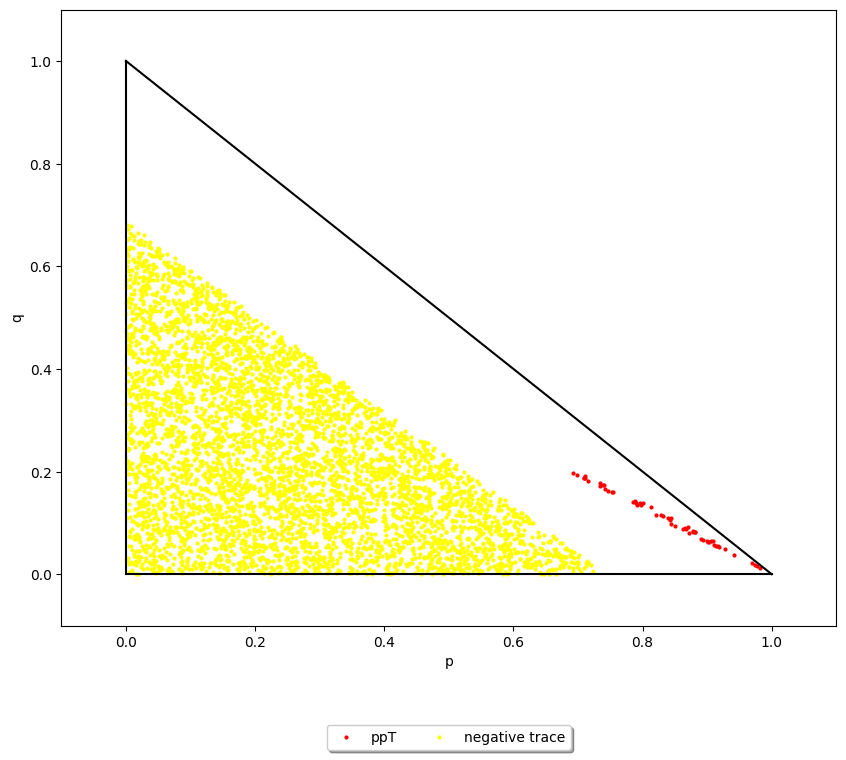

In [68]:
rho1 = maximally_entangled_qudit_state(3, 0)
rho2 = generate_Terhal_state(1)
rho3 = werner(3, 0.8)

sample_size = 10000
alpha = [1, 1, 1]
samples = np.random.dirichlet(alpha, sample_size)

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_ylim((-0.1, 1.1))
ax.set_xlim((-0.1, 1.1))
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.plot([0, 1], [0, 0], color='black')
ax.plot([0, 0], [0, 1], color='black')
ax.plot([0, 1], [1, 0], color='black')

EW = entanglement_witness_from_sdp(3, 3, rho1, transpose_map)

for i in range(sample_size):
    state = (samples[i, 0] * rho1) + (samples[i, 1] * rho2) + (samples[i, 2] * rho3)
    if is_ppPhi(3, 3, state, transpose_map):
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='r', alpha=1)
    if (np.trace(EW @ state) < 0):
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='yellow', alpha=1)
legend_labels = ['ppT', 'negative trace']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=4, label=label)
                   for color, label in zip(['r', 'yellow'], legend_labels)]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.show()
plt.close()

The set of states $\rho = (1-p-q)\sigma_1 + p \sigma_2 + q \sigma_3$, where 
$\sigma_1 = \frac{1}{3}\ket{\Omega}\bra{\Omega}$, $\sigma_2$ Terhal state fir `sec = 1` and $\sigma_3$ is the Werner state with $\alpha = 0.55$,
and its intersection with $\mathsf{PPT}$ and the half-space $\operatorname{tr}(W\rho)<0$, where $W$ is the witness obtained by `entanglement_witness_from_sdp(3, 3, rho1, transpose_map)`.

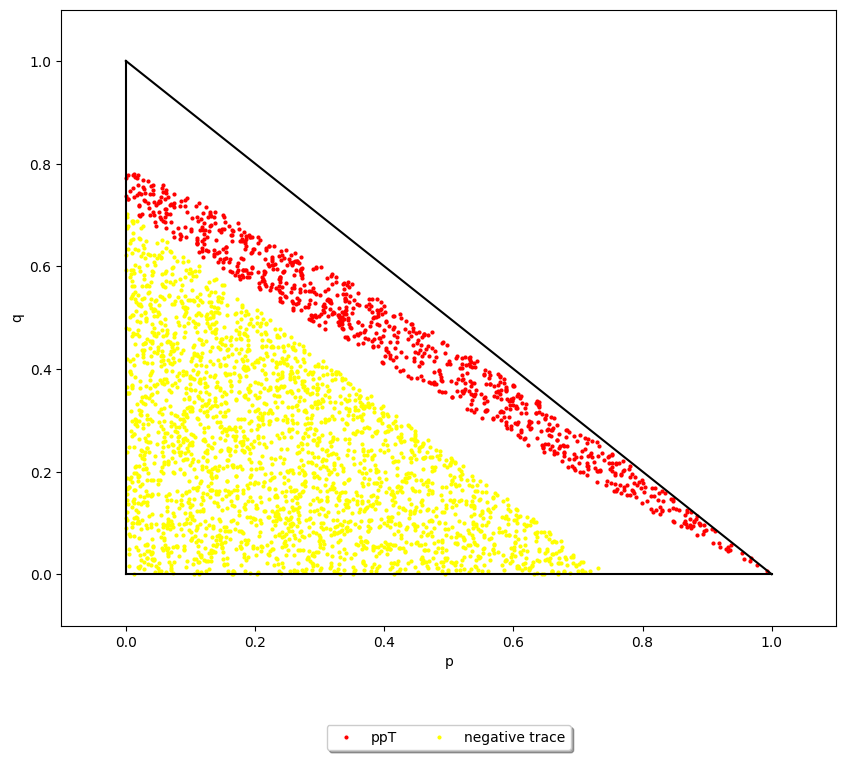

In [69]:
rho1 = maximally_entangled_qudit_state(3, 0)
rho2 = generate_Terhal_state(1)
rho3 = werner(3, 0.55)

sample_size = 5000
alpha = [1, 1, 1]
samples = np.random.dirichlet(alpha, sample_size)

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_ylim((-0.1, 1.1))
ax.set_xlim((-0.1, 1.1))
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.plot([0, 1], [0, 0], color='black')
ax.plot([0, 0], [0, 1], color='black')
ax.plot([0, 1], [1, 0], color='black')

EW = entanglement_witness_from_sdp(3, 3, rho1, transpose_map)

for i in range(sample_size):
    state = (samples[i, 0] * rho1) + (samples[i, 1] * rho2) + (samples[i, 2] * rho3)
    if is_ppPhi(3, 3, state, transpose_map):
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='r', alpha=1, label='ppT')
    if np.trace(EW @ state) < 0:
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='yellow', alpha=1, label='Negative Trace')

legend_labels = ['ppT', 'negative trace']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=4, label=label)
                   for color, label in zip(['r', 'yellow'], legend_labels)]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.show()
plt.close()


The set of states $\rho = (1-p-q)\sigma_1 + p \sigma_2 + q \sigma_3$, where 
$\sigma_1$ is the Werner state with $\alpha = 0.55$, $\sigma_2$ is the Terhal state with `sec = 1` and $\sigma_3 = \frac{1}{3}\ket{\Omega}\bra{\Omega}$,
and its intersection with $\mathsf{PPT}$ and the half-space $\operatorname{tr}(W\rho)<0$, where $W$ is the witness obtained by `entanglement_witness_from_sdp(3, 3, rho1, transpose_map)`.

The set of states $\rho = (1-p-q)\sigma_1 + p \sigma_2 + q \sigma_3$, where 
$\sigma_1 = \frac{1}{3}\ket{\Omega}\bra{\Omega}$, $\sigma_2$ is the Terhal state with `sec = 1` and $\sigma_3$ is the Werner state with $\alpha = 0.8$,
and its intersection with $\mathsf{PPT}$ and the half-space $\operatorname{tr}(W\rho)<0$, where $W$ is the witness obtained by `entanglement_witness_from_sdp(3, 3, rho1, transpose_map)`.

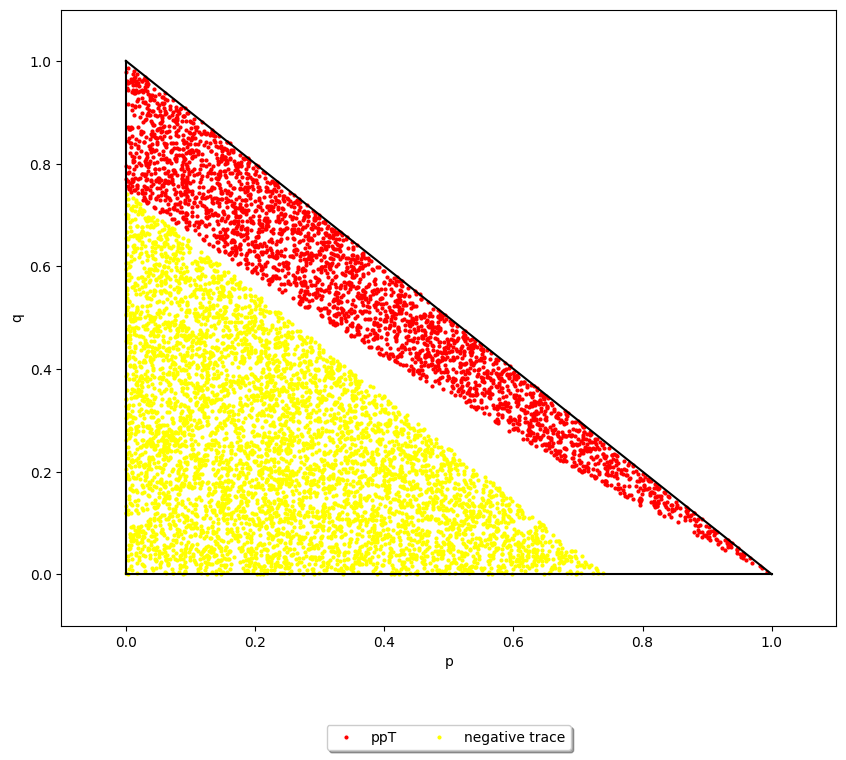

In [70]:
rho1 = maximally_entangled_qudit_state(3, 1)
rho2 = generate_Terhal_state(1)
rho3 = np.eye(9)/9

sample_size = 10000
alpha = [1, 1, 1]
samples = np.random.dirichlet(alpha, sample_size)

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_ylim((-0.1, 1.1))
ax.set_xlim((-0.1, 1.1))
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.plot([0, 1], [0, 0], color='black')
ax.plot([0, 0], [0, 1], color='black')
ax.plot([0, 1], [1, 0], color='black')

EW = entanglement_witness_from_sdp(3, 3, rho1, transpose_map)

for i in range(sample_size):
    state = (samples[i, 0] * rho1) + (samples[i, 1] * rho2) + (samples[i, 2] * rho3)
    if is_ppPhi(3, 3, state, transpose_map):
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='r', alpha=1, label='is_ppT')
    if (np.trace(EW @ state) < 0):
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='yellow', alpha=1, )

legend_labels = ['ppT', 'negative trace']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=4, label=label)
                   for color, label in zip(['r', 'yellow'], legend_labels)]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.show()
plt.close()

The set of states $\rho = (1-p-q)\sigma_1 + p \sigma_2 + q \sigma_3$, where 
$\sigma_1 = \frac{1}{3}\ket{\Omega}\bra{\Omega}$, $\sigma_2$ is the Terhal state with `sec = 1` and $\sigma_3 = \frac{1}{1- 0.4}(\frac{\mathbb{I}}{9}-0.4\rho_2)$,
and its intersection with $\mathsf{PPT}$ and the half-space $\operatorname{tr}(W\rho)<0$, where $W$ is the witness obtained by `entanglement_witness_from_sdp(3, 3, rho1, transpose_map)`. It appears that the hyperplane $\operatorname{tr}(W\rho)=0$ is tangent to $\mathsf{PPT}$ at the point where the segment connecting $\rho_1$ to $\frac{\mathbb{I}}{9}$ meets the boundary of $\mathsf{PPT}$.

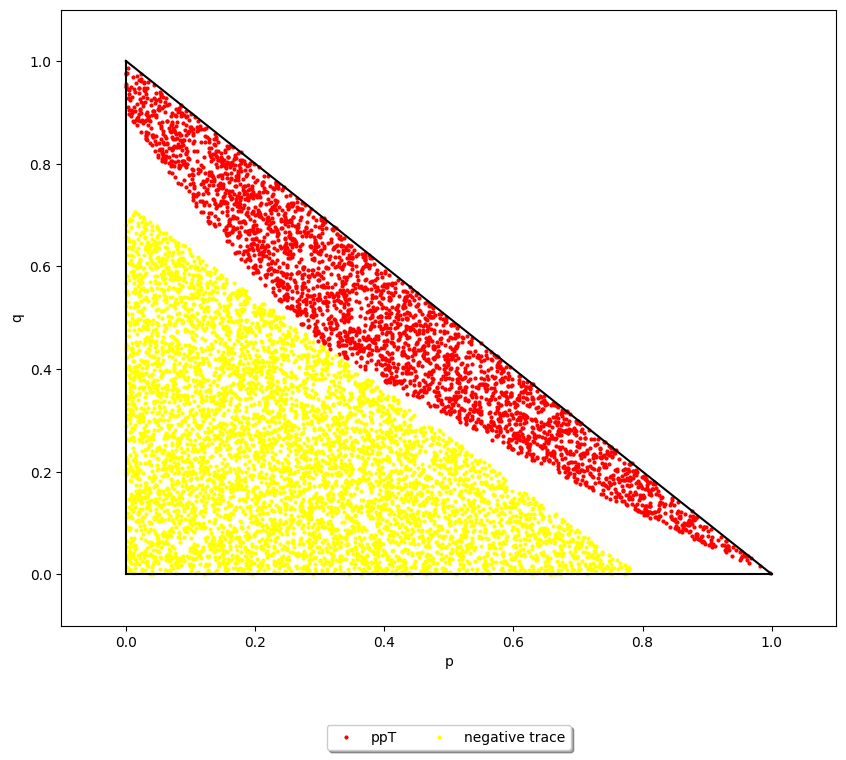

In [75]:
rho1 = maximally_entangled_qudit_state(3, 1)
rho2 = generate_Terhal_state(1)
rho3 = 10/6 * (np.eye(9)/9 - 0.4 * rho2)


sample_size = 10000
alpha = [1, 1, 1]
samples = np.random.dirichlet(alpha, sample_size)

fig, ax = plt.subplots(figsize=(10, 8))

ax.set_ylim((-0.1, 1.1))
ax.set_xlim((-0.1, 1.1))
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.plot([0, 1], [0, 0], color='black')
ax.plot([0, 0], [0, 1], color='black')
ax.plot([0, 1], [1, 0], color='black')

EW = entanglement_witness_from_sdp(3, 3, rho1, transpose_map)

for i in range(sample_size):
    state = (samples[i, 0] * rho1) + (samples[i, 1] * rho2) + (samples[i, 2] * rho3)
    if is_ppPhi(3, 3, state, transpose_map):
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='r', alpha=1, label='is_ppT')
    if (np.trace(EW @ state) < 0):
        ax.scatter(samples[i, 1], samples[i, 2], s=4, c='yellow', alpha=1, )

legend_labels = ['ppT', 'negative trace']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=4, label=label)
                   for color, label in zip(['r', 'yellow'], legend_labels)]

ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.show()
plt.close()

In the following, we replace $\sigma_1$ to be a random state that is not in $\mathsf{PPT}$, and we observe again that the entanglement witnesses are tangent to the boundary of $\mathsf{PPT}$.

The starting state is:
[[ 0.09049338+3.03819771e-19j  0.0290099 +6.09526145e-03j
   0.04513068-1.44037689e-02j  0.03491256-1.65992583e-02j
  -0.02151531-2.55433665e-02j -0.00329452-2.06953783e-02j
  -0.00525992-3.17102890e-02j  0.01075132-8.74659581e-03j
  -0.02967817-5.70232480e-02j]
 [ 0.0290099 -6.09526145e-03j  0.06981576+3.46363314e-19j
   0.01225932+7.13758507e-06j  0.02939083-1.71110638e-02j
   0.01781681-5.34661555e-03j  0.01462832-4.37324246e-02j
   0.03539956-2.61621598e-02j  0.01459542+1.52656121e-03j
   0.00607309-3.40169202e-02j]
 [ 0.04513068+1.44037689e-02j  0.01225932-7.13758507e-06j
   0.12008287+1.48010218e-18j  0.02390702-1.69073730e-02j
   0.03743703-2.02312352e-02j -0.01339443-2.83271675e-02j
  -0.00202081-4.09333604e-02j  0.05906411-1.80921604e-02j
   0.02317312-5.39425168e-02j]
 [ 0.03491256+1.65992583e-02j  0.02939083+1.71110638e-02j
   0.02390702+1.69073730e-02j  0.07258289+2.14186614e-19j
   0.01801497+2.15003557e-03j -0.0201233 -3.78416691e-02j
   0.04151771-

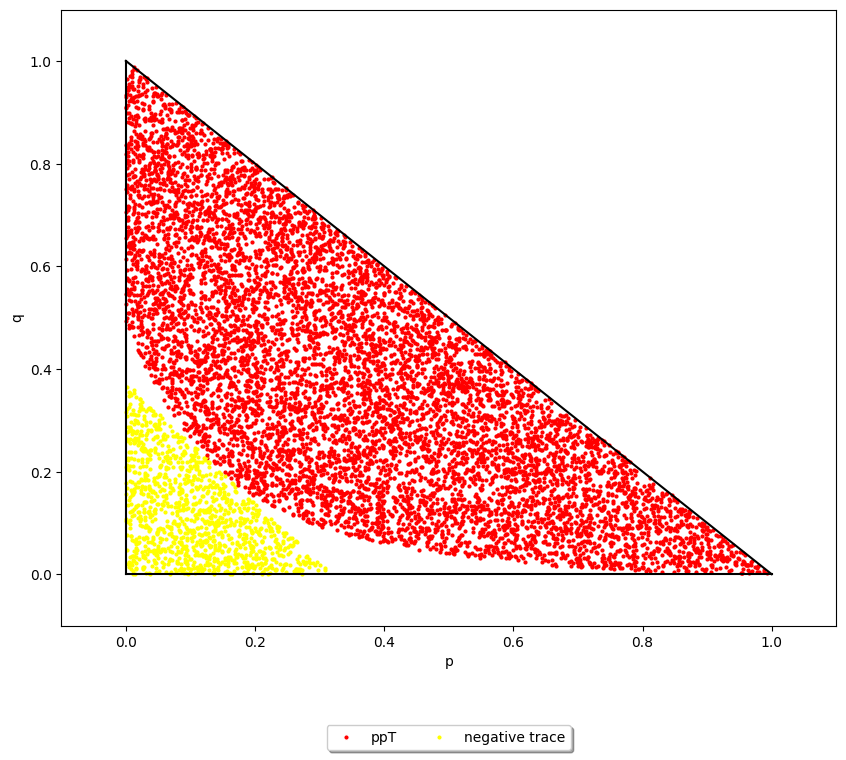

In [23]:
dim1 = dim2 = 3
for i in range(1):
    Phi = transpose_map
    rho1 = generate_random_density_matrix(dim1, dim2)
    while(is_ppPhi(dim1, dim2, rho1, Phi)):
        rho1 = generate_random_density_matrix(dim1, dim2)
    print("The starting state is:")
    print(rho1)
    rho2 = generate_Terhal_state(1)
    rho3 = 10/6 * (np.eye(9)/9 - 0.4 * rho2)
    
    
    sample_size = 10000
    alpha = [1, 1, 1]
    samples = np.random.dirichlet(alpha, sample_size)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_ylim((-0.1, 1.1))
    ax.set_xlim((-0.1, 1.1))
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.plot([0, 1], [0, 0], color='black')
    ax.plot([0, 0], [0, 1], color='black')
    ax.plot([0, 1], [1, 0], color='black')
    
    EW = entanglement_witness_from_sdp(3, 3, rho1, Phi)

    tol = 1e-10
  
    lower_bound1, lower_bound2, upper_bound1,  upper_bound2 = 0.0, 0.0, 1.0, 1.0

    T1, T2 = 0, 0
    while (upper_bound1 - lower_bound1 > tol): 
        T1 = (lower_bound1 + upper_bound1) / 2.0
        convex_combination1 = T1 * np.eye(9)/9 + (1 - T1) * rho1
        
        if is_ppPhi(dim1, dim2, convex_combination1, Phi):
            upper_bound1 = T1
        else:
            lower_bound1 = T1
        
    while (upper_bound2 - lower_bound2 > tol): 
        T2 = (lower_bound2 + upper_bound2) / 2.0
        convex_combination2 = T2 * np.eye(9)/9 + (1 - T2) * rho1
       
        if (np.trace(EW @ convex_combination2) >= 0):
            upper_bound2 = T2
        else:
            lower_bound2 = T2
    print("T1 is ", T1)
    print("T2 is ", T2)
    
    for i in range(sample_size):
        state = (samples[i, 0] * rho1) + (samples[i, 1] * rho2) + (samples[i, 2] * rho3)
        if is_ppPhi(3, 3, state, transpose_map):
            ax.scatter(samples[i, 1], samples[i, 2], s=4, c='r', alpha=1, label='is_ppT')
        if (np.trace(EW @ state) < 0):
            ax.scatter(samples[i, 1], samples[i, 2], s=4, c='yellow', alpha=1, )
    
    legend_labels = ['ppT', 'negative trace']
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=4, label=label)
                       for color, label in zip(['r', 'yellow'], legend_labels)]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    
    
    plt.savefig("sn.png")
    
    

The starting state is:
[[ 0.10273057-3.93383619e-19j  0.03855028-1.38759824e-02j
   0.02566266+1.30237989e-02j  0.05302254+1.51015782e-02j
  -0.00187547-1.82319935e-02j  0.01959512-4.03400730e-03j
   0.02048203-1.36118572e-02j  0.01377837+7.71482292e-03j
   0.05436079+8.20976702e-03j]
 [ 0.03855028+1.38759824e-02j  0.1042375 -1.52038564e-18j
  -0.0087352 +5.72568694e-04j -0.01188174+2.50701137e-02j
  -0.02328532-2.03060177e-02j -0.00520095+1.48761255e-03j
   0.00877162+1.19398067e-03j  0.06512832-1.26584285e-02j
   0.03607099+7.04873352e-03j]
 [ 0.02566266-1.30237989e-02j -0.0087352 -5.72568694e-04j
   0.13380974-8.56789825e-20j  0.01698226-1.66000826e-02j
   0.04209405+1.20791522e-02j  0.01441636-1.69626329e-02j
   0.01003494+2.85762343e-03j  0.03713716-5.59314651e-03j
   0.01776471-8.46984867e-03j]
 [ 0.05302254-1.51015782e-02j -0.01188174-2.50701137e-02j
   0.01698226+1.66000826e-02j  0.14022234-1.99212604e-19j
   0.00048725+1.56663225e-02j -0.00680917+1.71597831e-02j
  -0.01881734+

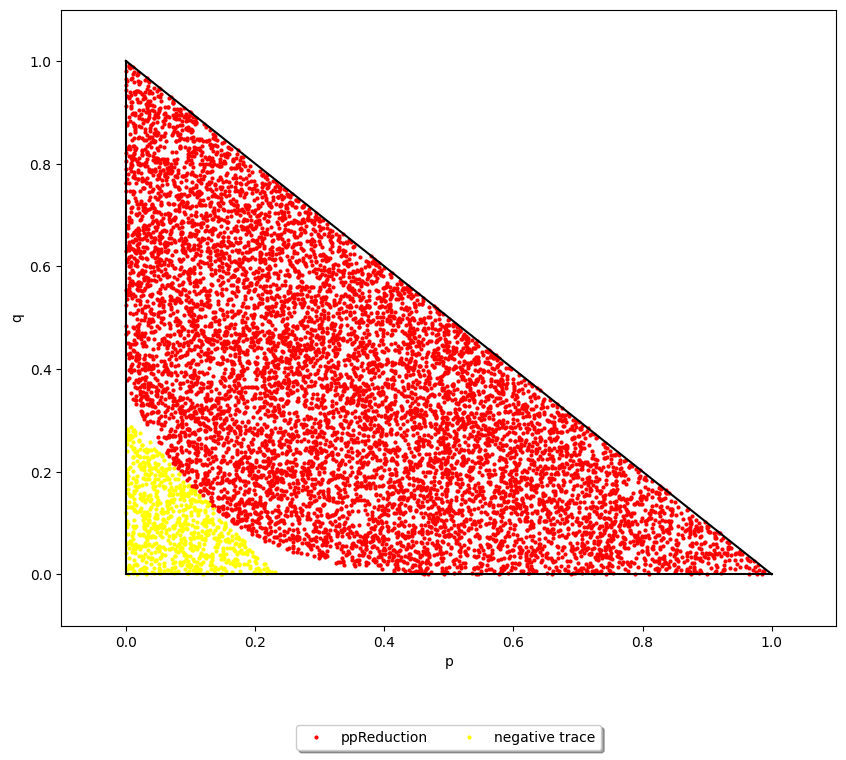

The starting state is:
[[ 8.54225629e-02+3.16003581e-19j  1.56303683e-02+5.74932851e-03j
   1.89178932e-02+6.25132834e-03j -3.63392254e-04-8.93767155e-03j
   1.63202463e-02-3.25301782e-03j  4.23648320e-02-3.01127868e-02j
   1.61937079e-02+7.58316635e-03j  3.35501464e-02-1.74231692e-02j
   8.42222927e-03-1.28209393e-02j]
 [ 1.56303683e-02-5.74932851e-03j  1.07094857e-01+1.58019622e-19j
  -1.29830642e-02+5.25119784e-03j  4.62550480e-04+1.67319249e-02j
   4.87891947e-02+2.04994625e-02j  3.47988724e-03-1.73123378e-02j
   3.37810683e-03-1.61893002e-02j  4.37071876e-03-3.11844785e-02j
  -2.17634670e-02+5.66893883e-03j]
 [ 1.89178932e-02-6.25132834e-03j -1.29830642e-02-5.25119784e-03j
   1.39121407e-01+2.59143249e-19j -1.57800431e-02-2.04685498e-02j
  -6.39156084e-02-1.55261240e-02j  8.90002197e-03-3.84217890e-02j
   2.36508197e-02-1.71442956e-02j -1.40010637e-04+6.34205129e-03j
   6.58569405e-02+1.21919636e-02j]
 [-3.63392254e-04+8.93767155e-03j  4.62550480e-04-1.67319249e-02j
  -1.57800431e

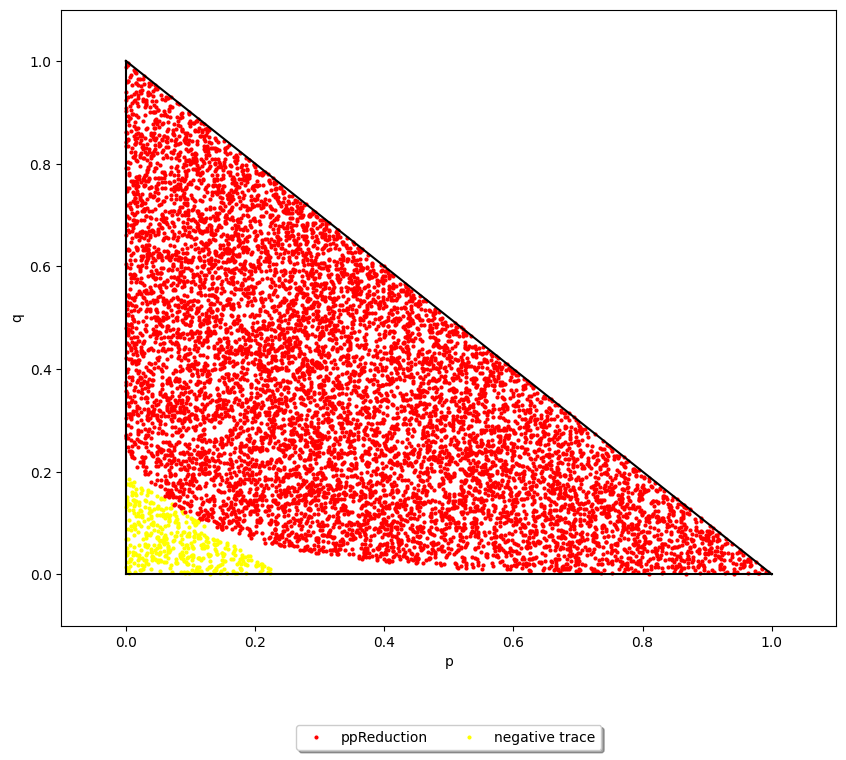

The starting state is:
[[ 0.13733206+9.16562291e-19j  0.03348549+1.59236483e-02j
  -0.0053992 -3.58325475e-02j  0.01576832-1.37027782e-02j
   0.01988873-9.87534064e-03j  0.02078426-1.32840778e-02j
   0.04926294-5.49182991e-02j  0.02070745-2.51421251e-02j
   0.02288226-4.23744790e-02j]
 [ 0.03348549-1.59236483e-02j  0.0520031 +2.27107940e-19j
  -0.00144232-2.00236097e-02j  0.012621  -3.96983037e-03j
   0.00465187-1.13710222e-02j -0.00606661+5.55392888e-04j
   0.01809455-1.59307349e-02j  0.01225298+1.24438716e-03j
   0.03373103-1.76575347e-02j]
 [-0.0053992 +3.58325475e-02j -0.00144232+2.00236097e-02j
   0.08425873+2.88188656e-19j  0.02348444+6.82485090e-03j
  -0.00088682+1.24418846e-02j  0.03322771+2.23212537e-02j
   0.0985992 +1.49727084e-02j  0.0206567 +1.96669252e-02j
   0.05956941-1.28898317e-02j]
 [ 0.01576832+1.37027782e-02j  0.012621  +3.96983037e-03j
   0.02348444-6.82485090e-03j  0.11246999-7.62760056e-19j
   0.01129789-1.25838421e-02j  0.04907094+1.00320971e-02j
   0.04565179+

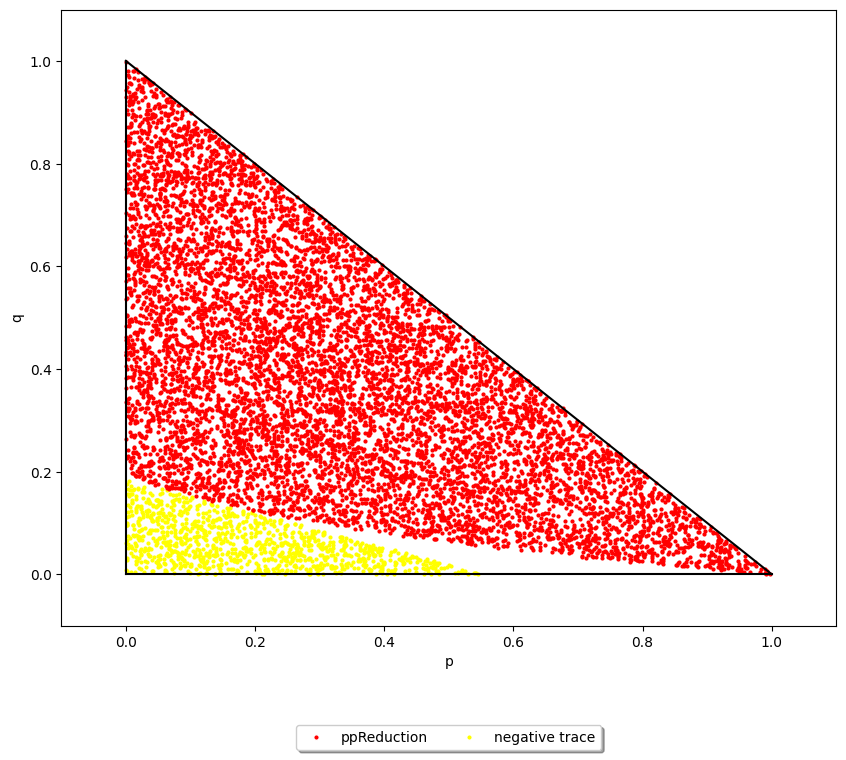

The starting state is:
[[ 0.06248409+6.95009156e-20j  0.01989132+1.48219451e-02j
  -0.02692583+4.10031735e-03j  0.01506166+1.05087323e-03j
   0.01795075+1.67392109e-02j  0.03314717+1.80355207e-03j
   0.061436  -6.20345085e-03j  0.06002447+3.82261106e-03j
   0.05776872-1.11721979e-02j]
 [ 0.01989132-1.48219451e-02j  0.11005114+7.96053471e-19j
  -0.00608303-3.89676438e-04j  0.02251985-9.84496703e-03j
   0.06052999+3.36449157e-03j  0.03245591+1.31341226e-02j
   0.0185843 -5.80030100e-02j -0.00802668-6.42907074e-03j
   0.04547394-2.99676896e-02j]
 [-0.02692583-4.10031735e-03j -0.00608303+3.89676438e-04j
   0.1434773 -1.66015983e-19j  0.0498336 -1.46412279e-02j
   0.06198541+1.54036947e-02j -0.01669189+3.38532353e-03j
  -0.00107604-3.80529274e-02j -0.0160847 +3.12252589e-03j
  -0.01260993-1.95250931e-02j]
 [ 0.01506166-1.05087323e-03j  0.02251985+9.84496703e-03j
   0.0498336 +1.46412279e-02j  0.05812774-3.95261508e-19j
   0.04014256+1.00638950e-02j  0.02037194+1.46763221e-02j
   0.05473921-

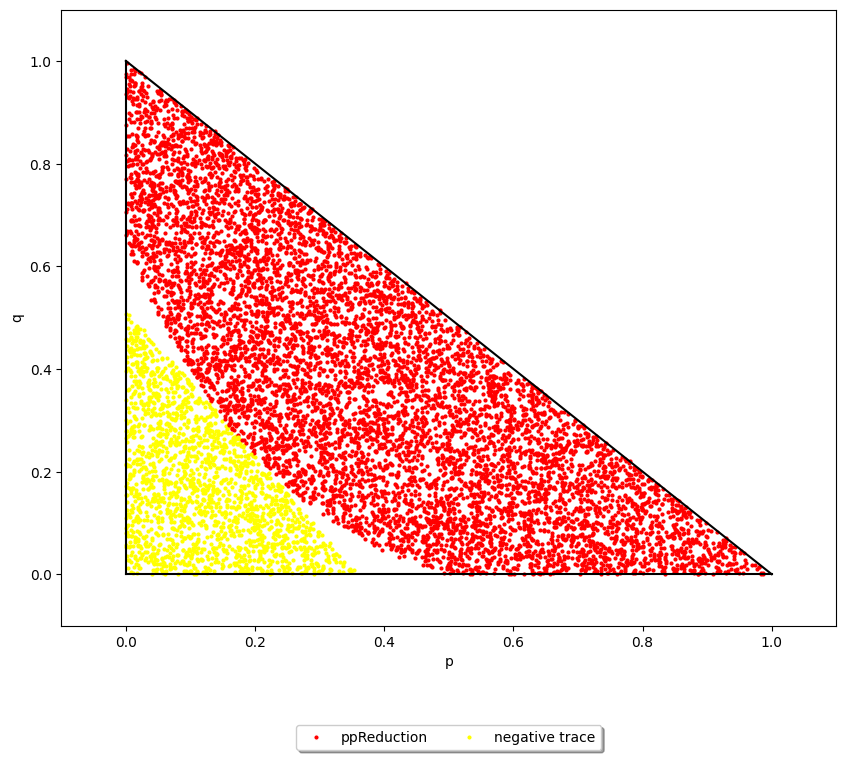

The starting state is:
[[ 0.07818547+4.11128797e-19j  0.02008115-7.51477692e-03j
   0.0143559 +1.83839879e-02j  0.031139  +9.00915494e-03j
   0.04722916+3.24342811e-02j  0.0110656 +1.36403193e-02j
   0.02978656+1.08655746e-02j  0.01599715-1.49087496e-02j
   0.0214028 +4.06139653e-02j]
 [ 0.02008115+7.51477692e-03j  0.10346076-6.43916835e-19j
   0.02176041+1.03696967e-02j  0.01089986-1.27009957e-02j
  -0.0189128 +1.71934105e-02j  0.03234239-2.62227010e-03j
   0.01242937+1.16698682e-02j -0.00139502-8.80717605e-03j
   0.02392193+2.84290929e-02j]
 [ 0.0143559 -1.83839879e-02j  0.02176041-1.03696967e-02j
   0.05126178+6.29190240e-19j  0.08434594+7.11568078e-03j
   0.07044722+1.54144652e-02j  0.00392624-1.58945893e-02j
   0.02450701-9.59444427e-03j  0.01390312-6.69211796e-03j
   0.03678012+1.19487632e-02j]
 [ 0.031139  -9.00915494e-03j  0.01089986+1.27009957e-02j
   0.08434594-7.11568078e-03j  0.23115193-8.61759882e-19j
   0.12362718+4.43958274e-02j -0.00226403+1.83887225e-03j
   0.02985195-

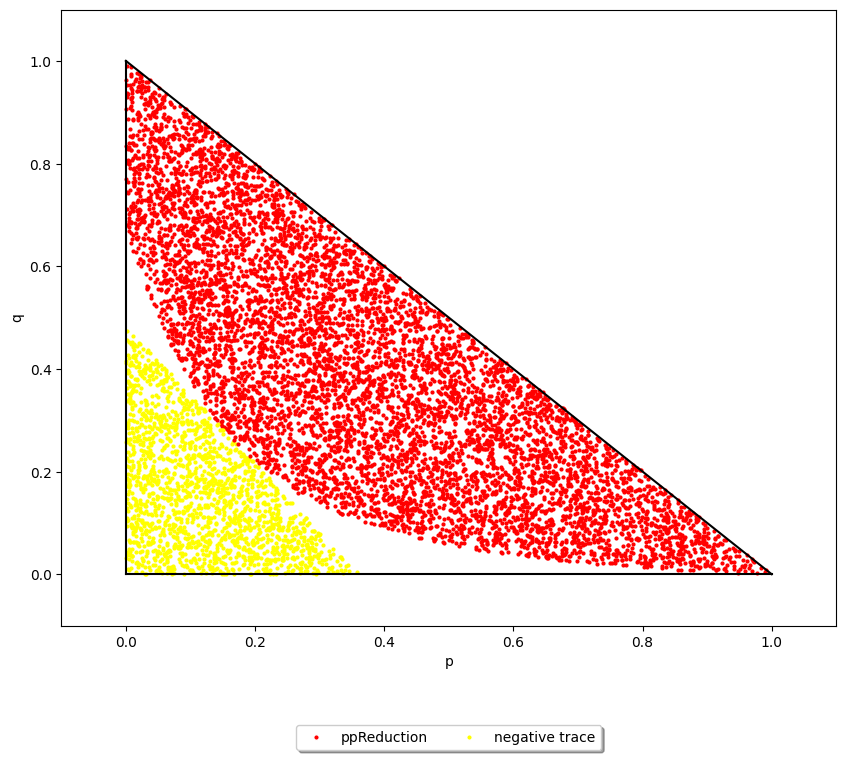

The starting state is:
[[ 0.07576806+1.86273200e-19j  0.0049377 +3.38388243e-03j
   0.06825944-1.50437925e-02j  0.02602519+2.40336424e-02j
   0.03735549+1.88213331e-03j  0.02205302+5.50594223e-03j
   0.01552377-1.12281140e-03j  0.00172666-1.60091364e-02j
   0.02950772+7.35963109e-03j]
 [ 0.0049377 -3.38388243e-03j  0.22251137-1.30515609e-18j
  -0.0092249 -5.41801200e-02j -0.02048406-5.33741790e-03j
   0.00871071-7.81425154e-03j  0.035687  -2.04022658e-02j
   0.01204397+2.59537543e-02j -0.02231128-5.27671064e-02j
   0.04697209-2.46529972e-03j]
 [ 0.06825944+1.50437925e-02j -0.0092249 +5.41801200e-02j
   0.1282227 +9.30994727e-19j  0.01258526+3.62156712e-02j
   0.03317727+2.38076691e-02j  0.02491108+2.30650166e-02j
   0.0320809 +9.39451178e-03j  0.03892783-1.57955908e-02j
   0.03089042+2.26453865e-02j]
 [ 0.02602519-2.40336424e-02j -0.02048406+5.33741790e-03j
   0.01258526-3.62156712e-02j  0.08910657+3.12005774e-19j
   0.03876097+1.78710960e-02j  0.05199082+1.02471853e-02j
   0.01581884-

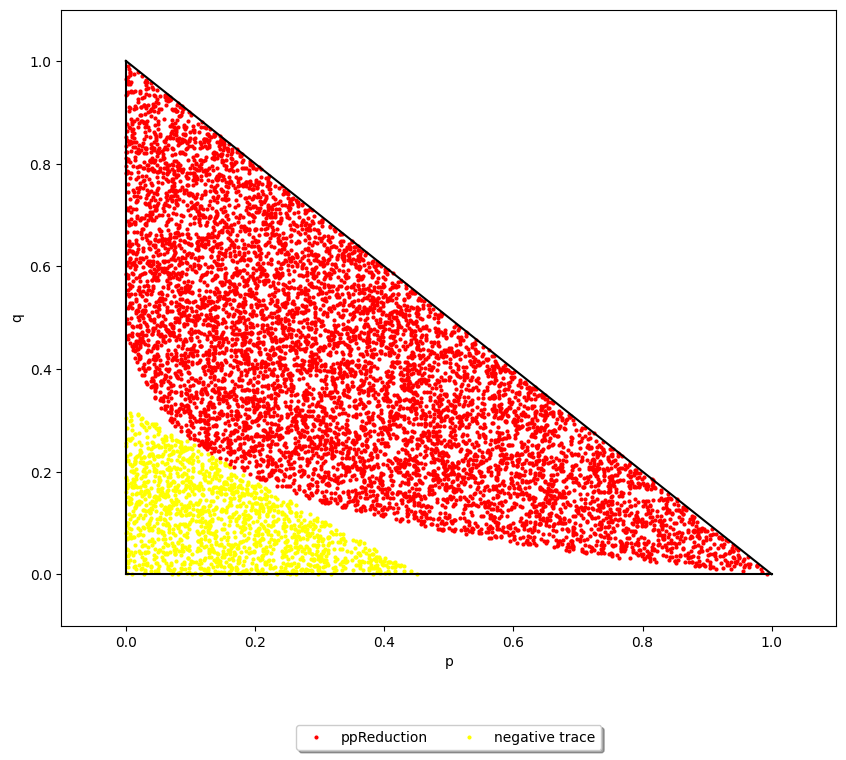

The starting state is:
[[ 0.10131294-9.84308111e-19j  0.00947293+3.81558603e-03j
   0.02025039+1.22942331e-02j  0.00783711+3.73065092e-02j
   0.00104877+3.81868082e-03j -0.01306755+3.54795733e-02j
   0.0358554 +5.56019692e-02j  0.02694314+2.23600374e-02j
   0.05662894-3.03536768e-02j]
 [ 0.00947293-3.81558603e-03j  0.12612141+6.16689430e-19j
   0.01344789+3.44259722e-02j  0.04555838+2.28209973e-02j
   0.03429804-7.93316693e-03j -0.00795284+1.44920891e-02j
   0.04979136-2.34801316e-02j  0.03130194-6.64382033e-03j
   0.0515355 -2.70590704e-04j]
 [ 0.02025039-1.22942331e-02j  0.01344789-3.44259722e-02j
   0.06808193+4.58924600e-20j  0.01722707+1.39920724e-02j
   0.01439097-2.56004453e-02j  0.00618656-1.49454116e-02j
   0.02666475+3.08634098e-03j  0.00266188-2.00531324e-02j
   0.02902259-2.36205707e-02j]
 [ 0.00783711-3.73065092e-02j  0.04555838-2.28209973e-02j
   0.01722707-1.39920724e-02j  0.11052469+1.07348854e-19j
   0.02758269-4.27917872e-02j  0.00780544+7.68398843e-03j
   0.06509847-

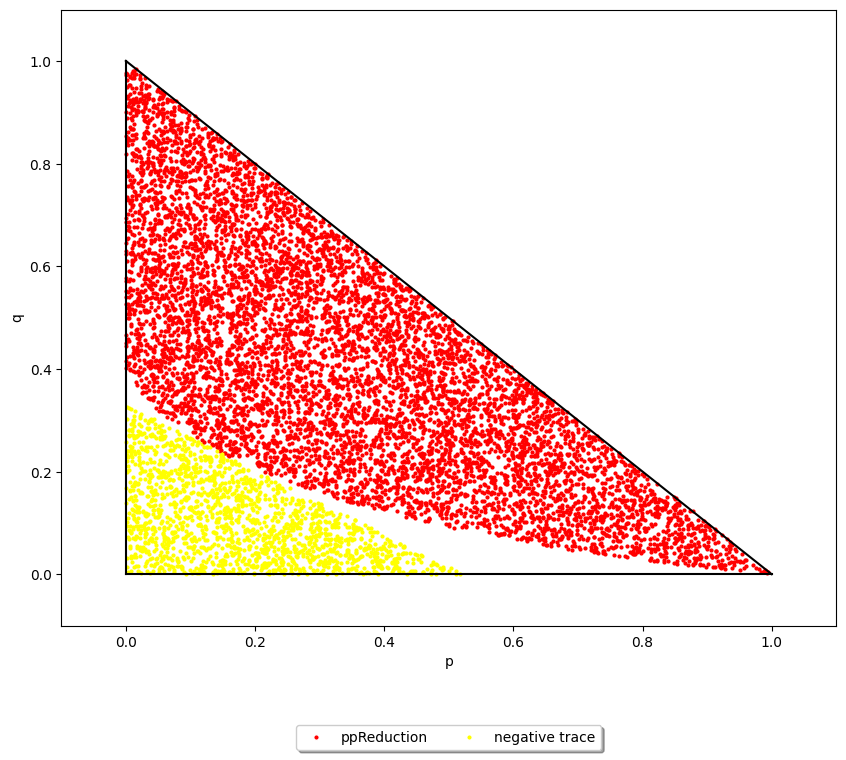

The starting state is:
[[ 0.13384855+6.72018792e-19j  0.0033977 +4.14700939e-02j
   0.00277076+9.90949583e-03j  0.06573398+5.48935235e-02j
   0.00950604+1.88340340e-02j -0.02047448+1.77513473e-02j
   0.05597859-5.08142967e-03j  0.03098184+2.62907751e-03j
   0.0202961 +1.21688575e-02j]
 [ 0.0033977 -4.14700939e-02j  0.0824146 -7.87586342e-19j
  -0.00231468+2.71828580e-06j  0.03266579-3.27014978e-02j
  -0.01274221+2.26723828e-03j  0.03883142-1.52848213e-02j
   0.01700684-7.76238487e-03j  0.02781265-1.52774788e-02j
   0.01279393-4.13883830e-02j]
 [ 0.00277076-9.90949583e-03j -0.00231468-2.71828580e-06j
   0.11698186+5.62232127e-19j -0.00373764+1.10119638e-02j
   0.02950732+2.51407867e-02j  0.05695806-2.44286428e-02j
  -0.04507543-1.75449279e-02j  0.03889058-8.02625253e-03j
   0.05803712+1.71892690e-03j]
 [ 0.06573398-5.48935235e-02j  0.03266579+3.27014978e-02j
  -0.00373764-1.10119638e-02j  0.16222024+7.15113169e-19j
   0.03157361+1.65922195e-03j -0.03880924-1.55981203e-02j
   0.01455284-

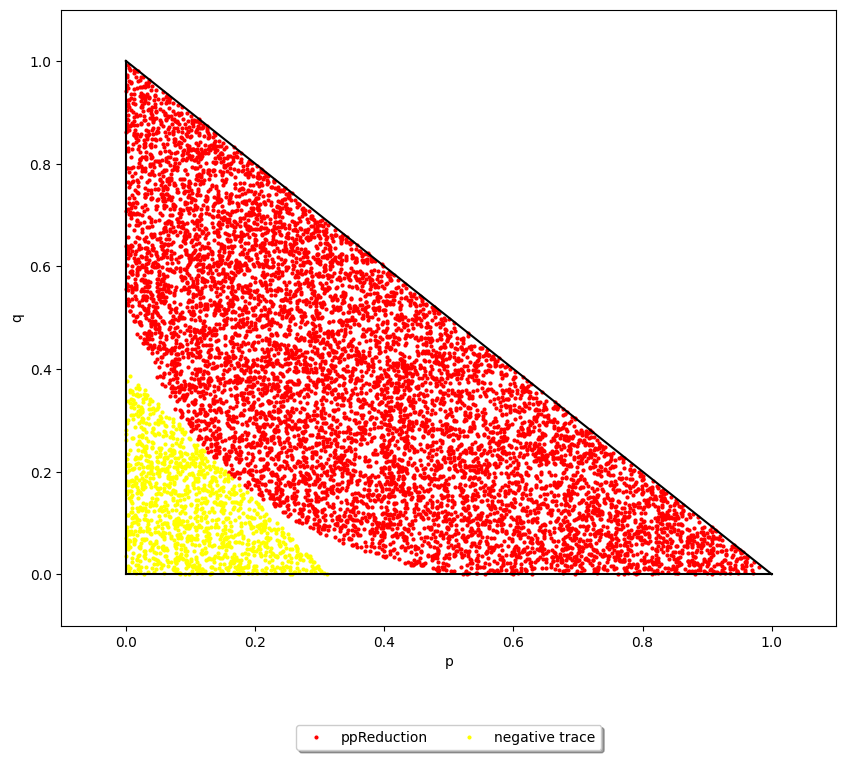

The starting state is:
[[ 0.10963051+4.90995931e-19j -0.05466289-1.50982181e-02j
  -0.0461609 -1.15730661e-02j  0.00803669+2.34956035e-03j
  -0.01621283+2.71327132e-03j -0.00266943+1.76383978e-02j
  -0.0081002 -5.91737548e-03j -0.0118436 -9.21969644e-03j
  -0.00299466-1.66086160e-02j]
 [-0.05466289+1.50982181e-02j  0.19407137+1.08239568e-18j
   0.09498501-2.69487433e-02j  0.06478615-5.37113043e-02j
   0.07333229-9.90713029e-03j  0.01675353-8.37836452e-03j
   0.07084992-5.73010148e-02j  0.04421085-3.08166370e-02j
   0.03695043+6.06282276e-03j]
 [-0.0461609 +1.15730661e-02j  0.09498501+2.69487433e-02j
   0.11581996+1.67481495e-19j  0.04555052-1.06650378e-02j
  -0.0002755 +3.69810535e-02j  0.0016311 +3.51592533e-02j
   0.03281065-2.61191115e-03j  0.02876854+6.03412563e-03j
   0.05522725+1.98649271e-02j]
 [ 0.00803669-2.34956035e-03j  0.06478615+5.37113043e-02j
   0.04555052+1.06650378e-02j  0.0915993 -5.27288570e-19j
   0.02194963+5.47024508e-02j  0.0032051 +3.10098833e-02j
   0.06151246+

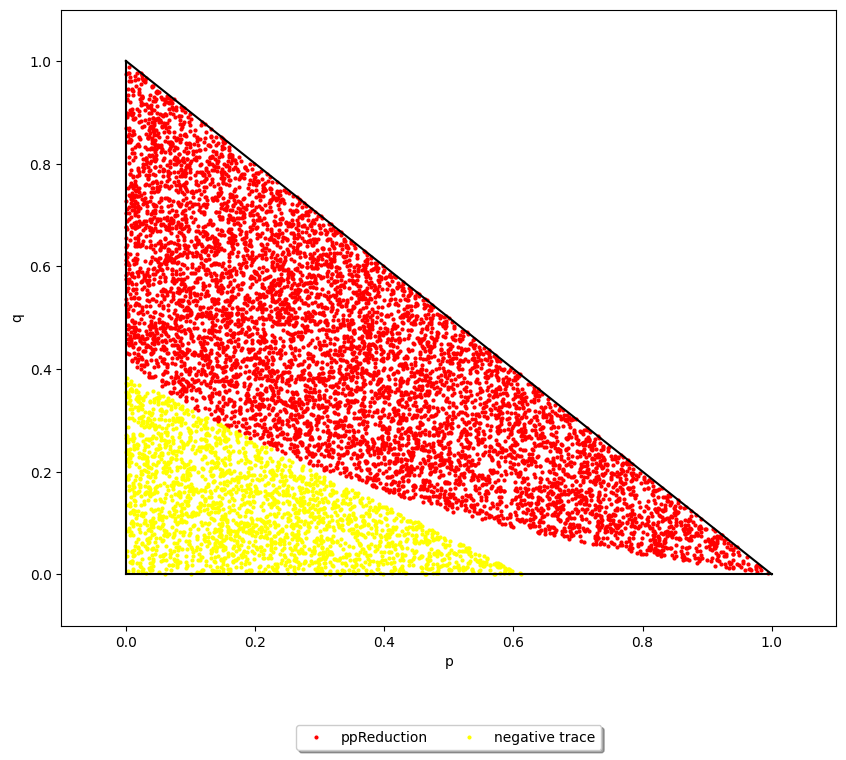

The starting state is:
[[ 1.33152716e-01+1.71697587e-19j -6.64991855e-03-3.08961281e-02j
   1.79695626e-02-6.62011589e-03j  2.42837751e-02-2.28552816e-02j
  -3.35804870e-02-2.28606341e-02j  2.49521264e-02-2.85623037e-02j
   1.41992526e-02-3.80975580e-02j  9.01862909e-03-5.93188186e-02j
   2.20350350e-02-3.77931669e-02j]
 [-6.64991855e-03+3.08961281e-02j  6.24609548e-02-3.29397017e-19j
   1.20699626e-02+2.18525305e-02j  1.48528132e-02+2.94261103e-02j
   3.84459104e-03-1.75125230e-02j  1.88183948e-02+3.64635124e-02j
  -5.74744667e-03-1.36307770e-02j  2.01584254e-02-1.24074501e-02j
   6.91004463e-03+5.64805651e-04j]
 [ 1.79695626e-02+6.62011589e-03j  1.20699626e-02-2.18525305e-02j
   7.67335123e-02-1.08693280e-18j  1.01817495e-02-1.08161793e-02j
   1.03960001e-02-3.35515550e-02j  2.17384889e-02+1.72944338e-02j
   1.32780742e-02-5.84707167e-03j -3.09210288e-03-3.70187009e-02j
   2.39702149e-02-3.37464561e-02j]
 [ 2.42837751e-02+2.28552816e-02j  1.48528132e-02-2.94261103e-02j
   1.01817495e

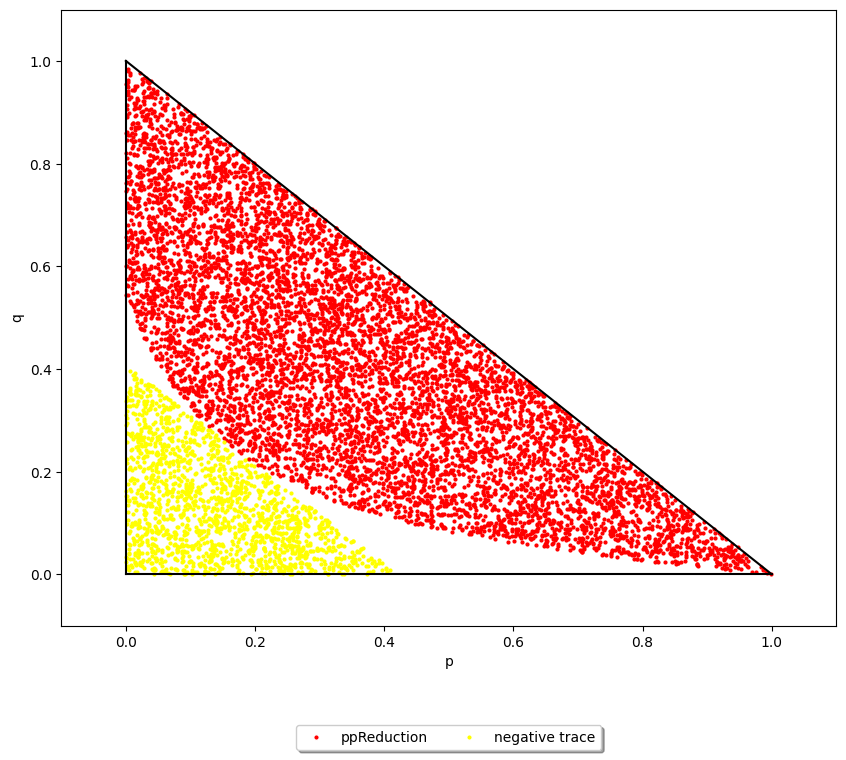

In [12]:
dim1 = dim2 = 3
for i in range(10):
    Phi = transpose_map
    rho1 = generate_random_density_matrix(dim1, dim2)
    while(is_ppPhi(dim1, dim2, rho1, Phi)):
        rho1 = generate_random_density_matrix(dim1, dim2)
    print("The starting state is:")
    print(rho1)
    rho2 = generate_Terhal_state(1)
    rho3 = 10/6 * (np.eye(9)/9 - 0.4 * rho2)
    
    
    sample_size = 10000
    alpha = [1, 1, 1]
    samples = np.random.dirichlet(alpha, sample_size)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_ylim((-0.1, 1.1))
    ax.set_xlim((-0.1, 1.1))
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.plot([0, 1], [0, 0], color='black')
    ax.plot([0, 0], [0, 1], color='black')
    ax.plot([0, 1], [1, 0], color='black')
    
    EW = entanglement_witness_from_sdp(3, 3, rho1, Phi)

    tol = 1e-10
  
    lower_bound1, lower_bound2, upper_bound1,  upper_bound2 = 0.0, 0.0, 1.0, 1.0

    T1, T2 = 0, 0
    while (upper_bound1 - lower_bound1 > tol): 
        T1 = (lower_bound1 + upper_bound1) / 2.0
        convex_combination1 = T1 * np.eye(9)/9 + (1 - T1) * rho1
        
        if is_ppPhi(dim1, dim2, convex_combination1, Phi):
            upper_bound1 = T1
        else:
            lower_bound1 = T1
        
    while (upper_bound2 - lower_bound2 > tol): 
        T2 = (lower_bound2 + upper_bound2) / 2.0
        convex_combination2 = T2 * np.eye(9)/9 + (1 - T2) * rho1
       
        if (np.trace(EW @ convex_combination2) >= 0):
            upper_bound2 = T2
        else:
            lower_bound2 = T2
    print("T1 is ", T1)
    print("T2 is ", T2)
    
    for i in range(sample_size):
        state = (samples[i, 0] * rho1) + (samples[i, 1] * rho2) + (samples[i, 2] * rho3)
        if is_ppPhi(3, 3, state, Phi):
            ax.scatter(samples[i, 1], samples[i, 2], s=4, c='r', alpha=1)
        if (np.trace(EW @ state) < 0):
            ax.scatter(samples[i, 1], samples[i, 2], s=4, c='yellow', alpha=1 )
    
    legend_labels = ['ppReduction', 'negative trace']
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=4, label=label)
                       for color, label in zip(['r', 'yellow'], legend_labels)]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    
    plt.show()
    plt.close()

The starting state is:
[[ 0.03714489+8.63220817e-19j  0.02705506+4.24141933e-02j
   0.01926384-1.71365026e-02j  0.01045083-1.08985278e-03j
  -0.00593204+3.16505923e-04j  0.0479435 +1.54703021e-02j
   0.026397  +1.72580995e-02j  0.03226216-2.87491633e-02j
   0.01743424-1.33566326e-02j]
 [ 0.02705506-4.24141933e-02j  0.12915401+1.86579845e-18j
  -0.05061734-4.85626927e-02j -0.02599215-3.54096106e-02j
   0.03099054-8.25497668e-03j  0.06005392-4.06335513e-02j
   0.05250422-3.00547353e-02j -0.011324  -6.87797599e-02j
  -0.0129871 -5.28411906e-02j]
 [ 0.01926384+1.71365026e-02j -0.05061734+4.85626927e-02j
   0.10854979-3.19599861e-19j  0.06551075+1.02363872e-02j
  -0.03713987-3.23632969e-03j  0.01538714+1.39876960e-02j
   0.02053348+2.32102291e-02j  0.02279691-2.23162668e-02j
   0.02531623+4.11699967e-04j]
 [ 0.01045083+1.08985278e-03j -0.02599215+3.54096106e-02j
   0.06551075-1.02363872e-02j  0.09429028-2.14745617e-19j
  -0.00777481+1.36785311e-02j  0.02104453+2.03992962e-03j
   0.02263098+

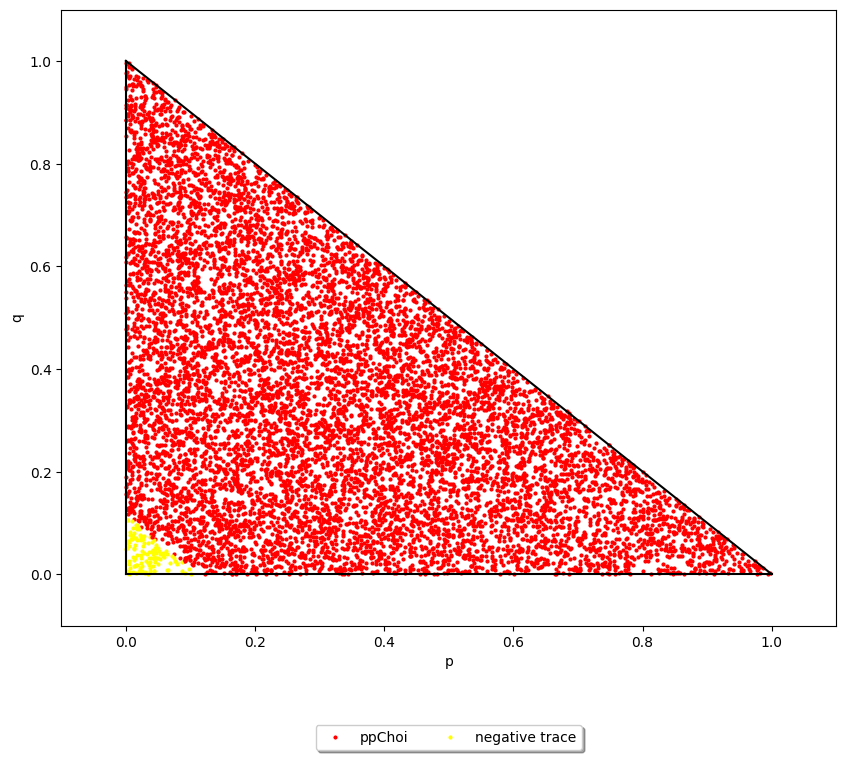

The starting state is:
[[ 0.12994765-1.54816081e-18j -0.00488071+4.91421601e-02j
   0.01390527+3.46600048e-02j  0.00770224+2.96765026e-02j
  -0.03261779+8.12688790e-03j  0.01461988+1.30609927e-03j
   0.02865023+1.73894700e-02j  0.10281973+1.50777907e-02j
  -0.02542829+3.63825222e-02j]
 [-0.00488071-4.91421601e-02j  0.08774681+5.78686823e-19j
   0.04497512-8.76257337e-03j  0.05310229-3.21851460e-02j
   0.02411165-2.21267355e-02j -0.00736225-5.43460388e-02j
   0.03604647-1.55236442e-02j  0.00229063-3.86129803e-02j
   0.03194667-1.60551366e-02j]
 [ 0.01390527-3.46600048e-02j  0.04497512+8.76257337e-03j
   0.06286257+7.74930649e-19j  0.04032977-1.77029558e-02j
   0.00512256+2.08029099e-03j  0.01892773-3.24683883e-02j
   0.01803219-5.66977137e-03j  0.0412137 -3.05384074e-02j
   0.02925928+3.76923855e-03j]
 [ 0.00770224-2.96765026e-02j  0.05310229+3.21851460e-02j
   0.04032977+1.77029558e-02j  0.09068628-6.48481778e-19j
   0.00791623+4.83971669e-03j  0.03535835-4.11270284e-02j
   0.01145549+

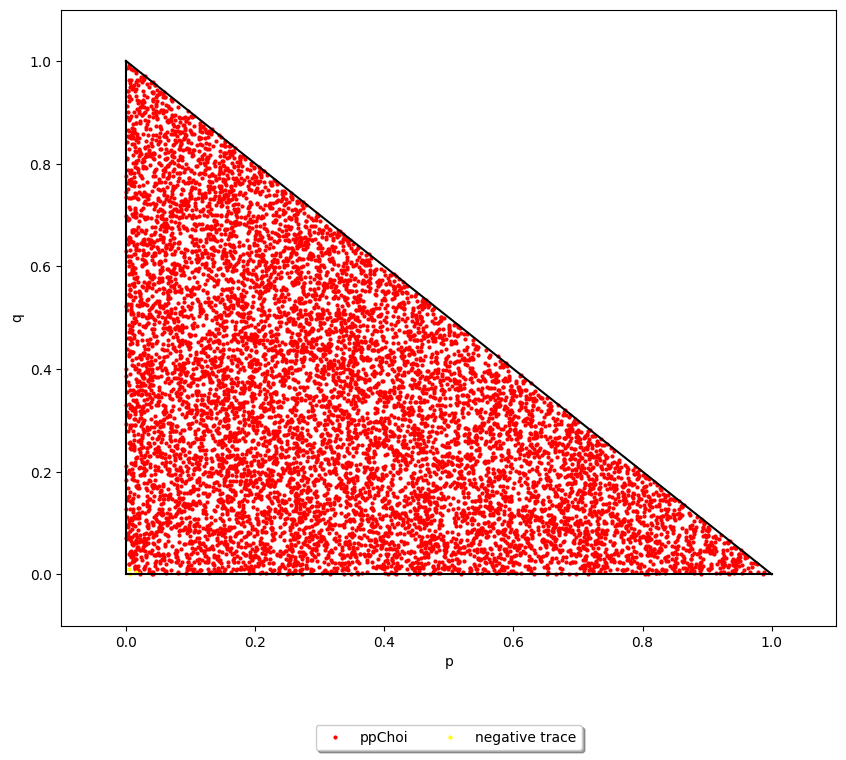

The starting state is:
[[ 0.09291113-3.54232327e-19j  0.01666415-8.10344969e-03j
   0.04279467-7.29220932e-03j -0.02502564-5.38999323e-03j
   0.00638471+2.17440485e-02j  0.06026717-2.06189234e-02j
   0.02283013+3.93096178e-02j  0.0293559 -1.13407616e-03j
   0.08384084-3.01269019e-02j]
 [ 0.01666415+8.10344969e-03j  0.09226945-4.78649430e-19j
   0.03408626-3.35857661e-03j  0.02557881+4.64309184e-03j
   0.01445428+2.84110811e-02j  0.02840479-1.78172152e-02j
   0.03738578+1.54133306e-02j  0.03419421+2.02353041e-02j
   0.03891432+2.89433410e-03j]
 [ 0.04279467+7.29220932e-03j  0.03408626+3.35857661e-03j
   0.1073542 +6.60888718e-19j  0.04479388-2.50518997e-02j
   0.04536564+4.76713931e-02j  0.04943116-1.12888851e-02j
   0.04783552+5.40647820e-02j  0.02246237+2.31800028e-03j
   0.04709876-2.89662120e-02j]
 [-0.02502564+5.38999323e-03j  0.02557881-4.64309184e-03j
   0.04479388+2.50518997e-02j  0.1401269 +6.65344191e-19j
   0.03088859+5.55821952e-02j  0.02744345-6.39660966e-03j
  -0.00934958+

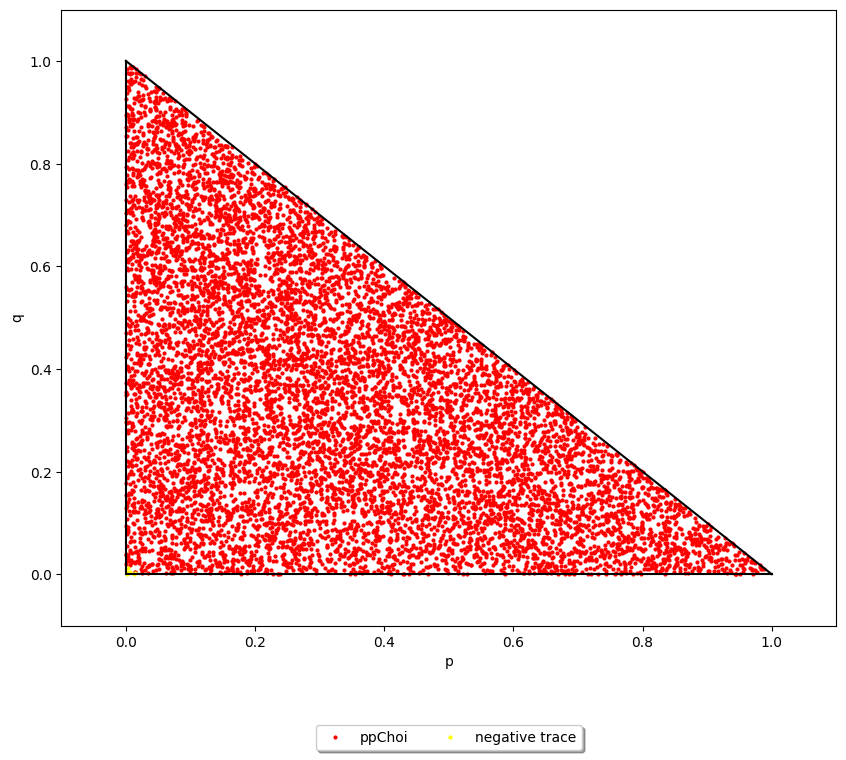

The starting state is:
[[ 0.08245616+4.96721135e-19j  0.03973866+5.62301108e-02j
   0.08747761+3.85547887e-02j  0.02578858+1.72000321e-02j
   0.03120329+3.06738789e-02j  0.04164588+4.99119139e-03j
   0.01739442+1.81074318e-02j  0.00082467+4.84829265e-02j
   0.06393129-1.15247504e-02j]
 [ 0.03973866-5.62301108e-02j  0.1048007 -8.08659438e-19j
   0.09596134-4.51335830e-02j  0.01796343-2.45258419e-03j
   0.02813302-1.28161359e-02j -0.00405904-1.28537964e-02j
   0.03404577-1.77128262e-02j  0.04895879+4.15540116e-02j
   0.03314726-4.91294581e-02j]
 [ 0.08747761-3.85547887e-02j  0.09596134+4.51335830e-02j
   0.18103054+1.64757958e-18j  0.02393911+3.82693921e-02j
   0.05764885+1.14184857e-02j -0.00672742-1.62836842e-02j
   0.04248732-1.69619400e-03j  0.04120561+6.61972611e-02j
   0.07583127-3.07000262e-02j]
 [ 0.02578858-1.72000321e-02j  0.01796343+2.45258419e-03j
   0.02393911-3.82693921e-02j  0.07242361-2.62769796e-19j
   0.02987042-5.53698692e-03j  0.018741  +8.79031224e-03j
   0.02611993+

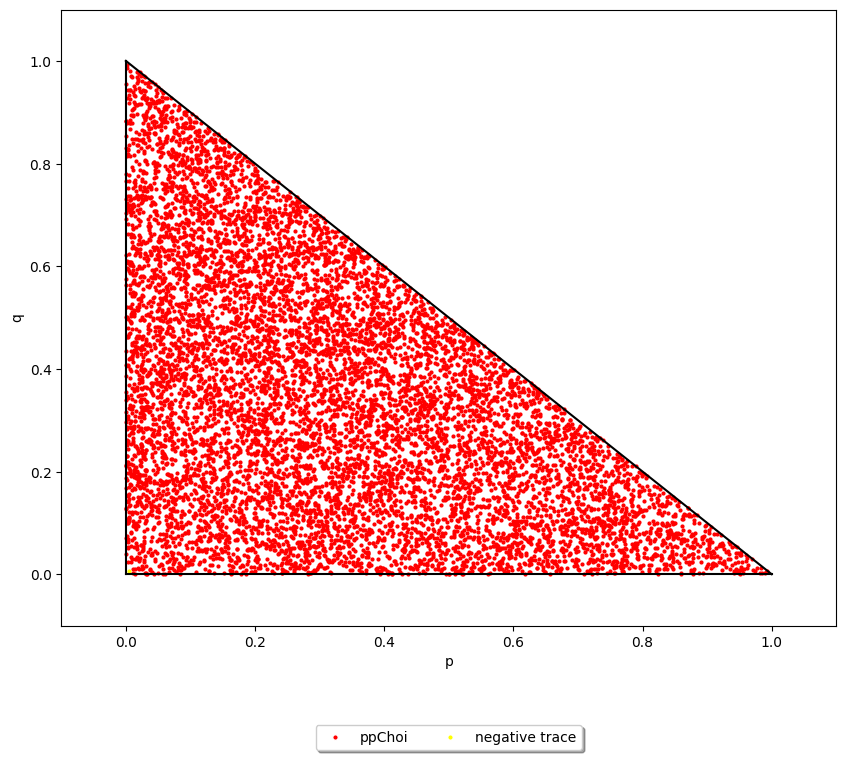

The starting state is:
[[ 0.14375034+4.00733889e-19j  0.01522899+5.23005313e-03j
  -0.02153757+2.02417956e-02j  0.05548939+5.25881291e-02j
   0.08247832+3.59138144e-02j  0.04604865-1.19540152e-02j
   0.00620403-2.12056194e-02j  0.05793809+1.39382574e-02j
   0.06978643+1.09275107e-02j]
 [ 0.01522899-5.23005313e-03j  0.1065193 +1.19375048e-18j
   0.08781288+2.29751450e-02j  0.05972313+1.64539761e-02j
   0.03714214+4.73219876e-03j  0.04523506-6.47579216e-03j
   0.05304646-1.28368469e-02j  0.05750424+2.29977640e-02j
   0.06652867+5.08479424e-03j]
 [-0.02153757-2.02417956e-02j  0.08781288-2.29751450e-02j
   0.15072809+3.38819696e-20j  0.06214203-1.09223098e-03j
   0.00525943+1.48103932e-02j  0.01018238-2.38891412e-02j
   0.05168536-1.12934996e-02j  0.05193312+1.79052575e-03j
   0.01807715-1.21965605e-02j]
 [ 0.05548939-5.25881291e-02j  0.05972313-1.64539761e-02j
   0.06214203+1.09223098e-03j  0.11302305+2.11838520e-20j
   0.0665805 -1.45724023e-02j  0.01119666-2.95346997e-02j
  -0.00351993-

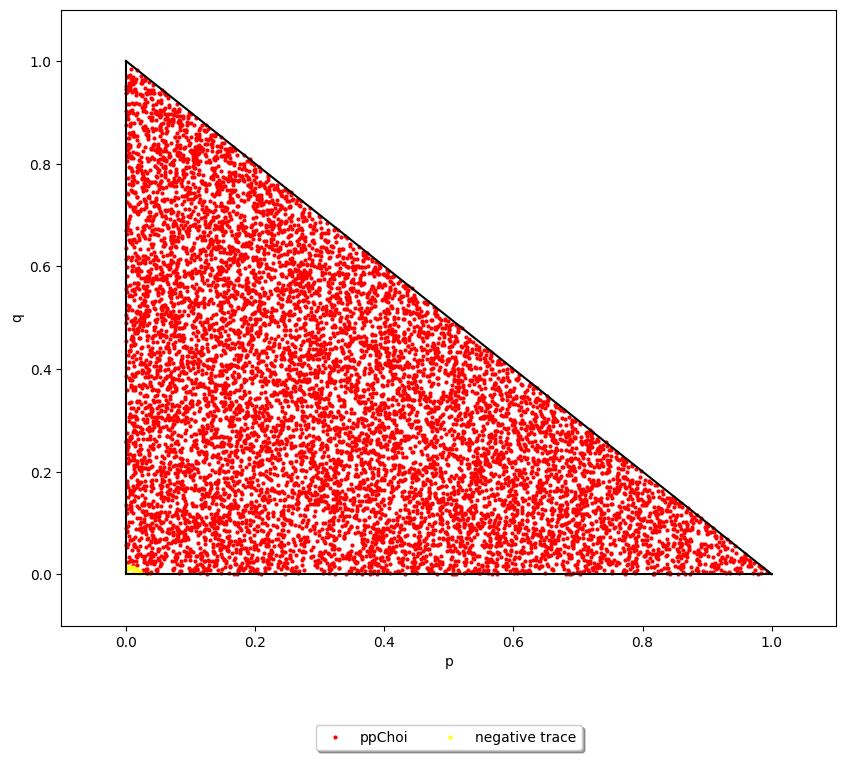

The starting state is:
[[ 0.07214178-3.04312266e-20j  0.01248679-8.29529516e-03j
   0.04291973-4.00122712e-02j  0.00810905-5.49226539e-05j
   0.03571862+2.45110064e-02j  0.00093139+1.48818201e-02j
   0.01816124-2.15044963e-02j  0.04215736+2.14585349e-02j
   0.03151479+1.13665060e-02j]
 [ 0.01248679+8.29529516e-03j  0.08597834+1.94868425e-19j
   0.01340735-2.56735531e-02j  0.03558466-7.48493763e-03j
   0.0233592 +3.91667611e-02j  0.01728993+2.03064393e-02j
   0.00893249-3.00816670e-03j  0.03612265+3.94936423e-02j
   0.03783087-1.26001784e-02j]
 [ 0.04291973+4.00122712e-02j  0.01340735+2.56735531e-02j
   0.1293861 +1.15922363e-19j  0.01687789+6.08973810e-02j
   0.02655231+5.31052904e-02j  0.00763427+1.64045485e-02j
   0.08010181-2.43996134e-02j  0.00480254+1.06597526e-01j
   0.03132717+2.00516170e-02j]
 [ 0.00810905+5.49226539e-05j  0.03558466+7.48493763e-03j
   0.01687789-6.08973810e-02j  0.10466777-5.38571515e-19j
   0.00912843+2.17662889e-02j -0.00129592+2.97560923e-02j
  -0.02236552-

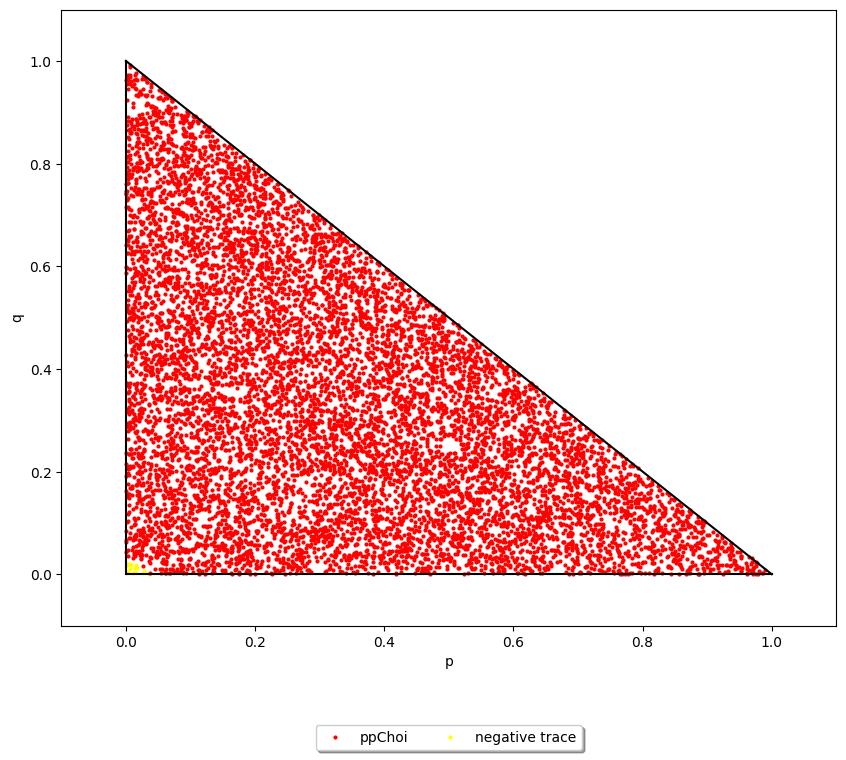

The starting state is:
[[ 1.14629576e-01+1.33875770e-19j  4.45443449e-02-9.14889935e-03j
   1.32841959e-02+1.97840300e-02j  4.15629859e-02+5.57191341e-03j
   4.25398101e-02+6.35039110e-04j  2.12873849e-02-5.42695120e-02j
   3.04471210e-02-2.05453941e-03j  2.22853462e-02+1.07300936e-02j
  -1.66207044e-02-5.59568016e-02j]
 [ 4.45443449e-02+9.14889935e-03j  8.57405626e-02-3.17056638e-19j
   3.48690552e-02-4.11009542e-03j -1.39102318e-05-6.37895592e-03j
   1.61746116e-02-1.03430629e-02j  5.44279131e-02-3.26451459e-02j
   2.72921782e-02-2.19383704e-03j  1.14632257e-02-9.37508274e-03j
   2.59802446e-02-2.30240676e-02j]
 [ 1.32841959e-02-1.97840300e-02j  3.48690552e-02+4.11009542e-03j
   1.04059745e-01-7.83434512e-20j  3.10928288e-02-1.75599259e-02j
   3.70886521e-02-3.49816933e-02j  1.09288155e-02-4.96295677e-02j
   4.14592442e-02-2.05514891e-02j  1.91685627e-02-1.21130788e-02j
   2.27585237e-02-5.35586883e-02j]
 [ 4.15629859e-02-5.57191341e-03j -1.39102318e-05+6.37895592e-03j
   3.10928288e

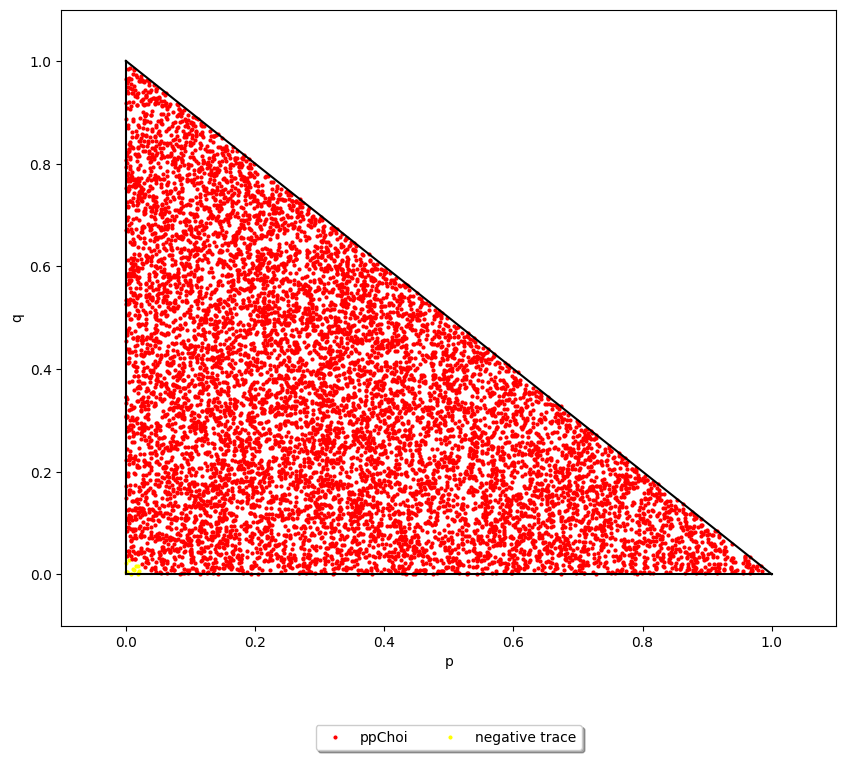

The starting state is:
[[ 0.08227355+8.81948809e-19j  0.00963708+3.94703007e-02j
   0.06948483-9.65148541e-03j  0.00764406+4.21168526e-02j
   0.03498245+1.57038310e-02j  0.03761859+2.16510899e-03j
   0.04405514-5.27350384e-03j  0.02910428+1.22832317e-03j
   0.02352044+4.91909433e-02j]
 [ 0.00963708-3.94703007e-02j  0.08401472-1.08200871e-18j
   0.02333353-4.20871833e-02j  0.03311341-2.08971641e-02j
   0.00344826-2.42912275e-02j  0.05836106-2.51589403e-02j
  -0.00073693-1.53749719e-02j  0.04311848-6.86301311e-03j
   0.03368247-1.84530012e-02j]
 [ 0.06948483+9.65148541e-03j  0.02333353+4.20871833e-02j
   0.12069867+1.61836404e-18j  0.07066187+2.93160981e-02j
   0.04954287-1.95728968e-03j  0.03151059+5.46393313e-03j
   0.05226263+1.10660432e-02j  0.05699703+2.14641857e-04j
   0.03786191+4.14378730e-02j]
 [ 0.00764406-4.21168526e-02j  0.03311341+2.08971641e-02j
   0.07066187-2.93160981e-02j  0.18509033+7.44749955e-19j
   0.05617448-2.59567751e-02j -0.01641759-1.42016209e-02j
   0.04617834+

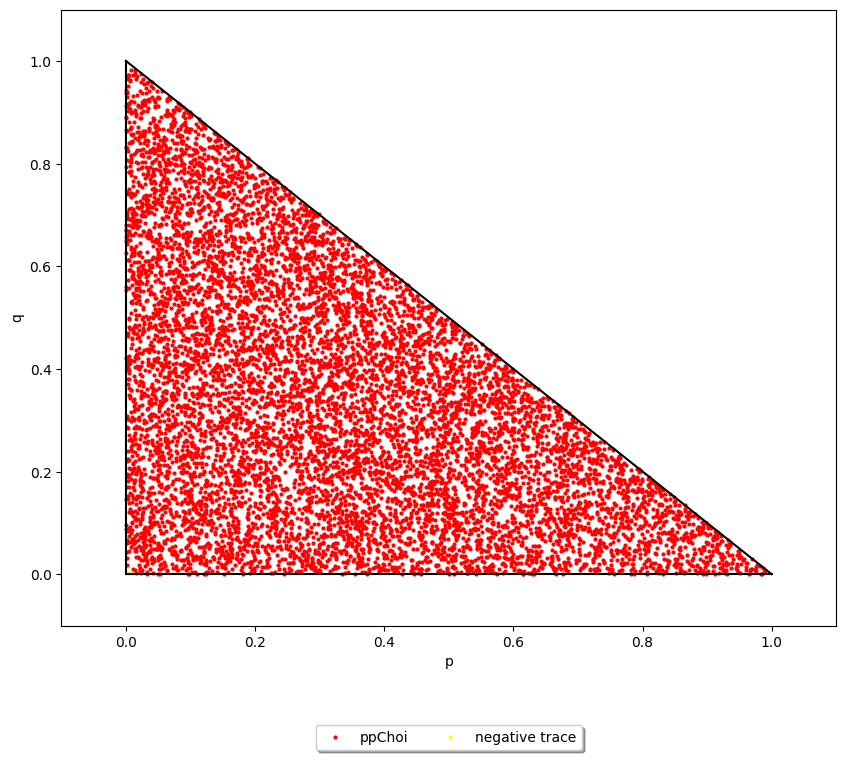

The starting state is:
[[ 0.07289808-2.63026140e-19j  0.04008209+6.84520232e-03j
   0.01157437+5.06877759e-03j  0.0341078 +1.78980625e-02j
   0.01587615+1.00514678e-02j  0.0104084 -1.20204900e-02j
  -0.01069038+1.97051436e-02j  0.05593159-5.88331685e-03j
   0.02916255+4.08938907e-02j]
 [ 0.04008209-6.84520232e-03j  0.14350071+2.38179973e-19j
  -0.03744562+1.36184680e-02j  0.08265115+9.64143830e-05j
  -0.03063196+8.42379666e-03j  0.06516829-1.47693985e-02j
   0.02833043+1.26402512e-02j  0.08689391-2.00633343e-02j
   0.00986289+4.90240936e-02j]
 [ 0.01157437-5.06877759e-03j -0.03744562-1.36184680e-02j
   0.13358527+1.19838084e-18j -0.03075525+1.03391617e-02j
   0.00758885-4.24464464e-03j -0.01786664-2.20570873e-02j
   0.04884145+1.05598540e-02j -0.04342023+1.76442823e-02j
   0.02804183+2.33091003e-03j]
 [ 0.0341078 -1.78980625e-02j  0.08265115-9.64143830e-05j
  -0.03075525-1.03391617e-02j  0.10858062-8.35929112e-19j
   0.000557  +2.99601176e-03j  0.04281442-1.26388771e-03j
   0.00717929+

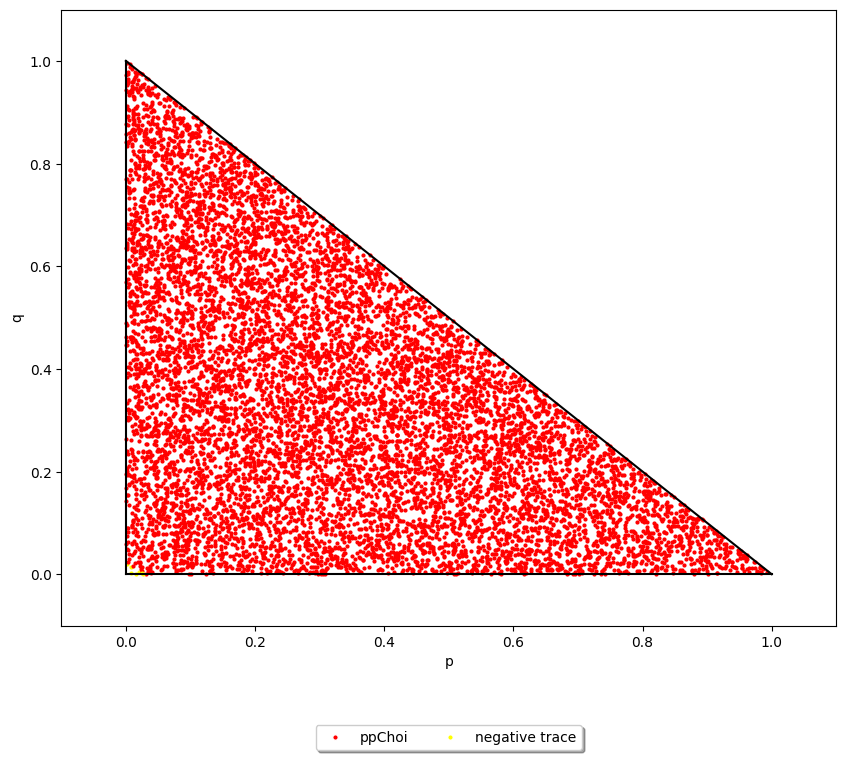

The starting state is:
[[ 0.05503241+7.54544764e-20j  0.02611716+2.77522387e-03j
   0.04232692-6.20900401e-03j  0.02039756+4.37835993e-02j
   0.02939632+3.45764934e-04j  0.02996216+4.10074614e-02j
   0.02107167+8.54195297e-03j  0.01900933+5.15959275e-02j
   0.02429025-1.03423282e-02j]
 [ 0.02611716-2.77522387e-03j  0.08860386-1.73345114e-19j
   0.00327075+1.51423165e-02j  0.02872924+3.88880211e-02j
   0.02482196-3.57032776e-03j  0.0734716 +2.53411791e-02j
   0.04851062+2.27256353e-04j  0.02200566+1.38843918e-03j
   0.03151711-1.21515559e-02j]
 [ 0.04232692+6.20900401e-03j  0.00327075-1.51423165e-02j
   0.10238611+7.13261350e-19j  0.03168533+2.24833087e-02j
   0.00802276-2.99103726e-02j -0.01649274+9.17882311e-03j
   0.01643564-3.10141677e-02j  0.00079719+3.72695658e-02j
  -0.01676197-4.93753298e-02j]
 [ 0.02039756-4.37835993e-02j  0.02872924-3.88880211e-02j
   0.03168533-2.24833087e-02j  0.10588067+4.21940000e-19j
   0.01012281-2.49571823e-02j  0.07957747-3.70807405e-02j
   0.03189205-

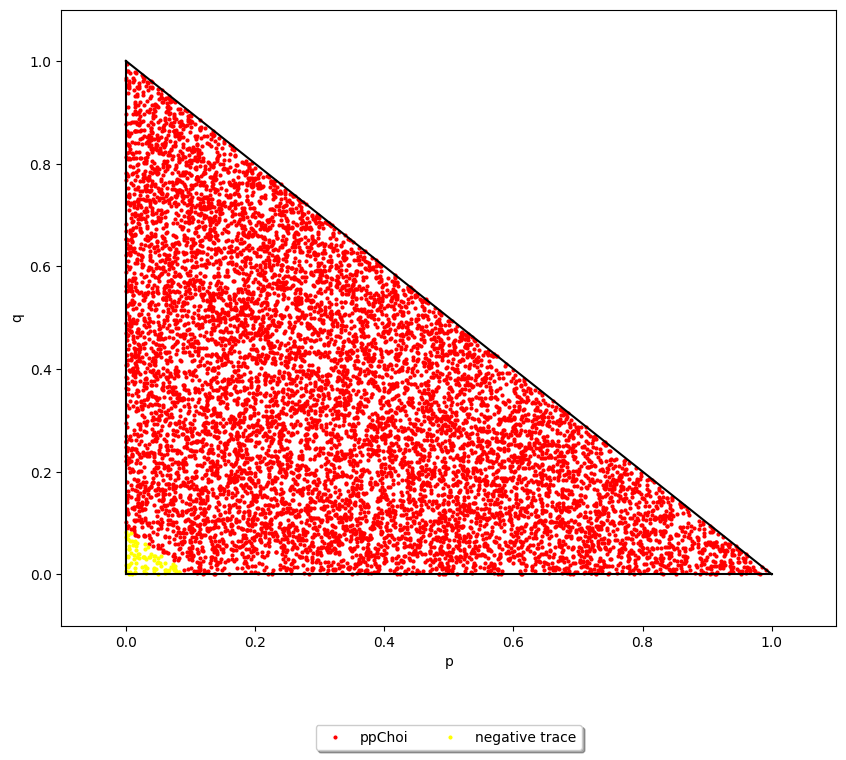

In [13]:
dim1 = dim2 = 3
for i in range(10):
    Phi = choi_map_3times3
    rho1 = generate_random_density_matrix(dim1, dim2)
    while(is_ppPhi(dim1, dim2, rho1, Phi)):
        rho1 = generate_random_density_matrix(dim1, dim2)
    print("The starting state is:")
    print(rho1)
    rho2 = generate_Terhal_state(1)
    rho3 = 10/6 * (np.eye(9)/9 - 0.4 * rho2)
    
    
    sample_size = 10000
    alpha = [1, 1, 1]
    samples = np.random.dirichlet(alpha, sample_size)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_ylim((-0.1, 1.1))
    ax.set_xlim((-0.1, 1.1))
    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.plot([0, 1], [0, 0], color='black')
    ax.plot([0, 0], [0, 1], color='black')
    ax.plot([0, 1], [1, 0], color='black')
    
    EW = entanglement_witness_from_sdp(3, 3, rho1, Phi)

    tol = 1e-10
  
    lower_bound1, lower_bound2, upper_bound1,  upper_bound2 = 0.0, 0.0, 1.0, 1.0

    T1, T2 = 0, 0
    while (upper_bound1 - lower_bound1 > tol): 
        T1 = (lower_bound1 + upper_bound1) / 2.0
        convex_combination1 = T1 * np.eye(9)/9 + (1 - T1) * rho1
        
        if is_ppPhi(dim1, dim2, convex_combination1, Phi):
            upper_bound1 = T1
        else:
            lower_bound1 = T1
        
    while (upper_bound2 - lower_bound2 > tol): 
        T2 = (lower_bound2 + upper_bound2) / 2.0
        convex_combination2 = T2 * np.eye(9)/9 + (1 - T2) * rho1
       
        if (np.trace(EW @ convex_combination2) >= 0):
            upper_bound2 = T2
        else:
            lower_bound2 = T2
    print("T1 is ", T1)
    print("T2 is ", T2)
    
    for i in range(sample_size):
        state = (samples[i, 0] * rho1) + (samples[i, 1] * rho2) + (samples[i, 2] * rho3)
        if is_ppPhi(3, 3, state, Phi):
            ax.scatter(samples[i, 1], samples[i, 2], s=4, c='r', alpha=1)
        if (np.trace(EW @ state) < 0):
            ax.scatter(samples[i, 1], samples[i, 2], s=4, c='yellow', alpha=1)
    
    legend_labels = ['ppChoi', 'negative trace']
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=4, label=label)
                       for color, label in zip(['r', 'yellow'], legend_labels)]
    
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    
    plt.show()
    plt.close()